# Aula8: Pandas & Matplotlib (Cont...) & Econometria

In [1]:
import pandas as pd
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.chdir("/Users/gustavorsampaio/Documents/Cursos/Python 2021.2/Aulas/aula6/")

In [3]:
countries = pd.read_pickle("countries.pkl")
leagues = pd.read_pickle("leagues.pkl")
matches = pd.read_pickle("matches.pkl")
teams = pd.read_pickle("teams.pkl")
player = pd.read_pickle("player.pkl")
player_attributes = pd.read_pickle("player_attributes.pkl")
sequence = pd.read_pickle("sequence.pkl")
team_attributes = pd.read_pickle("team_attributes.pkl")
lat_long = pd.read_pickle("lat_long.pkl")

Realizar todas as construções que fizemos nas aulas passadas

In [4]:
os.environ['PROJ_LIB'] = '/Users/gustavorsampaio/anaconda3/share/proj'
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import itertools
import random
import warnings
warnings.filterwarnings("ignore")

In [5]:
countries_leagues = countries.merge(leagues,left_on="id",right_on="id",how="outer", indicator=True)
countries_leagues = countries_leagues.drop("id",axis = 1)
countries_leagues = countries_leagues.rename(columns={'name_x':"country", 'name_y':"league"})
matches_new = matches[['id', 'country_id', 'league_id', 'season', 'stage', 'date',
                       'match_api_id', 'home_team_api_id', 'away_team_api_id',
                       'home_team_goal', 'away_team_goal']]
matches_new = matches_new.drop("id",axis=1)
data = matches_new.merge(countries_leagues,left_on="country_id",right_on="country_id",how="outer")
country_info  = countries_leagues.merge(lat_long,left_on="country",right_on="name",how="left")
country_info  = country_info.drop(["country_id","country_y","name"],axis = 1)

data["date"] = pd.to_datetime(data["date"],format="%Y-%m-%d")
data["year"] = pd.DatetimeIndex(data["date"]).year
data = data.merge(teams,left_on="home_team_api_id",right_on="team_api_id",how="left") # use only keys from left frame
data = data.drop(["id","team_api_id",'team_fifa_api_id'],axis = 1)
data = data.rename(columns={ 'team_long_name':"home_team_lname",'team_short_name':"home_team_sname"})
data = data.merge(teams,left_on="away_team_api_id",right_on="team_api_id",how="left")
data = data.drop(["id","team_api_id",'team_fifa_api_id'],axis = 1)
data = data.rename(columns={ 'team_long_name':"away_team_lname",'team_short_name':"away_team_sname"})
h_t = data.groupby("home_team_lname")["home_team_goal"].sum().reset_index()
a_t = data.groupby("away_team_lname")["away_team_goal"].sum().reset_index()
h_t = h_t.sort_values(by="home_team_goal",ascending= False)
a_t = a_t.sort_values(by="away_team_goal",ascending= False)
x = h_t
x = x.rename(columns={'home_team_lname':"team", 'home_team_goal':"goals"})
y = a_t
y = y.rename(columns={'away_team_lname':"team", 'away_team_goal':"goals"})
goals = pd.concat([x,y])
goals = goals.groupby("team")["goals"].sum().reset_index().sort_values(by = "goals",ascending = False)
x = data.groupby("home_team_lname")["match_api_id"].count().reset_index()
x = x.rename(columns={"home_team_lname":"team"})
y = data.groupby("away_team_lname")["match_api_id"].count().reset_index()
y = y.rename(columns={"away_team_lname":"team"})
xy = pd.concat([x,y],axis=0)
match_teams =  xy.groupby("team")["match_api_id"].sum().reset_index().sort_values(by="match_api_id",ascending =False)
match_teams = match_teams.rename(columns={"match_api_id":"matches_played"})
ts = list(goals["team"][:50])
v = data[["home_team_lname","away_team_lname"]]
v = v[(v["home_team_lname"].isin(ts)) & (v["away_team_lname"].isin(ts))]
x = data.groupby(["home_team_lname","league"]).agg({"match_api_id":"count","home_team_goal":"sum"}).reset_index()
y = data.groupby(["away_team_lname","league"]).agg({"match_api_id":"count","away_team_goal":"sum"}).reset_index()
x = x.rename(columns={'home_team_lname':"team", 'match_api_id':"matches", 'home_team_goal':"goals"})
y = y.rename(columns={'away_team_lname':"team", 'match_api_id':"matches", 'away_team_goal':"goals"})
xy = pd.concat([x,y])
xy = xy.groupby(["team","league"])[["matches","goals"]].sum().reset_index()
xy = xy.sort_values(by="goals",ascending=False)
data["total_goal"] = data["home_team_goal"]+data["away_team_goal"]
a = data.groupby("season").agg({"total_goal":"sum"})
m = data.groupby("season").agg({"total_goal":"mean"})
s = data.groupby("season").agg({"total_goal":"std"})
x = data.groupby("season").agg({"total_goal":"max"})
xx = a.merge(m,left_index=True,right_index=True,how="left")
yy = s.merge(x,left_index=True,right_index=True,how="left")
x_y = xx.merge(yy,left_index=True,right_index=True,how="left").reset_index()
x_y = x_y.rename(columns={'total_goal_x_x':"goals", 'total_goal_y_x':"mean",
                          'total_goal_x_y':"std",'total_goal_y_y':"max"})

### Criar novas colunas na base

Time Vencedor

In [6]:
def label(data):
    if data["home_team_goal"] > data["away_team_goal"]:
        return data["home_team_lname"]
    elif data["away_team_goal"] > data["home_team_goal"]:
        return data["away_team_lname"]
    elif data["home_team_goal"] == data["away_team_goal"]:
        return "DRAW"

data["win"] = data.apply(lambda data:label(data),axis=1)

Outcome do jogo

In [7]:
def lab(data):
    if data["home_team_goal"] > data["away_team_goal"]:
        return "HOME TEAM WIN"
    elif data["away_team_goal"] > data["home_team_goal"]:
        return "AWAY TEAM WIN"
    elif data["home_team_goal"] == data["away_team_goal"]:
        return "DRAW"

data["outcome_side"] = data.apply(lambda data:lab(data),axis = 1)

Time Perdedor

In [8]:
def labe(data):
    if data["home_team_goal"] < data["away_team_goal"]:
        return data["home_team_lname"]
    elif data["away_team_goal"] < data["home_team_goal"]:
        return data["away_team_lname"]
    elif data["home_team_goal"] == data["away_team_goal"]:
        return "DRAW"

data["lost"] = data.apply(lambda data:labe(data),axis = 1)

In [11]:
data.head()

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,_merge,year,home_team_lname,home_team_sname,away_team_lname,away_team_sname,total_goal,win,outcome_side,lost
0,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,1,...,both,2008,KRC Genk,GEN,Beerschot AC,BAC,2,DRAW,DRAW,DRAW
1,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,0,...,both,2008,SV Zulte-Waregem,ZUL,Sporting Lokeren,LOK,0,DRAW,DRAW,DRAW
2,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,3,...,both,2008,KSV Cercle Brugge,CEB,RSC Anderlecht,AND,3,RSC Anderlecht,AWAY TEAM WIN,KSV Cercle Brugge
3,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,0,...,both,2008,KAA Gent,GEN,RAEC Mons,MON,5,KAA Gent,HOME TEAM WIN,RAEC Mons
4,1,1,2008/2009,1,2008-08-16,492477,7947,9985,1,3,...,both,2008,FCV Dender EH,DEN,Standard de Liège,STL,4,Standard de Liège,AWAY TEAM WIN,FCV Dender EH


### Proporção dos jogos por outcome

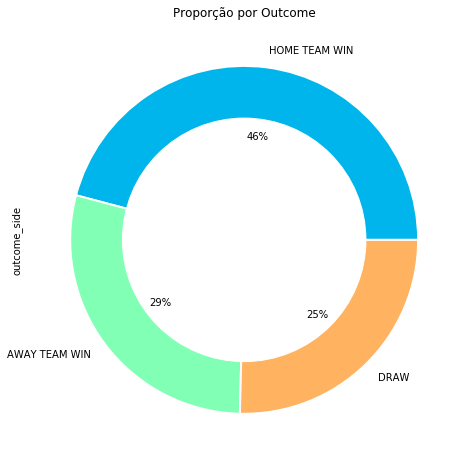

In [343]:
plt.figure(figsize=(8,8))
data["outcome_side"].value_counts().plot.pie(autopct = "%1.0f%%", # Mostrar o valor percentual
                                             colors =sns.color_palette("rainbow",3),
                                             wedgeprops = {"linewidth":2,"edgecolor":"white"})

my_circ = plt.Circle((0,0),.7,color = "white") # Experimenta tirar essa linha do plot
plt.gca().add_artist(my_circ)
plt.title("Proporção por Outcome")
plt.show()

In [9]:
win = data["win"].value_counts()[1:].reset_index()
lost = data["lost"].value_counts()[1:].reset_index()

In [14]:
win.head()

,index,win
0,FC Barcelona,234
1,Real Madrid CF,228
2,Celtic,218
3,FC Bayern Munich,193
4,Manchester United,192


#### Juntar win,draw e lost dos times com of jogos

In [15]:
xy.head()

,team,league,matches,goals
75,FC Barcelona,Spain LIGA BBVA,304,849
211,Real Madrid CF,Spain LIGA BBVA,304,843
49,Celtic,Scotland Premier League,304,695
77,FC Bayern Munich,Germany 1. Bundesliga,272,653
184,PSV,Netherlands Eredivisie,272,652


In [10]:
f = xy.merge(win,left_on="team",right_on="index",how="left")
f = f.drop("index",axis =1)
f = f.rename(columns={"outcome":"wins"})
f = f.merge(lost,left_on="team",right_on="index",how="left")
f = f.drop("index",axis =1)
dr = data[data["outcome_side"] == "DRAW"][["home_team_lname","away_team_lname"]]
l  = dr["home_team_lname"].value_counts().reset_index()
v  = dr["away_team_lname"].value_counts().reset_index()
l  = l.rename(columns={'index':"team", 'home_team_lname':"draw"})
v  = v.rename(columns={'index':"team", 'away_team_lname':"draw"})
lv = pd.concat([l,v])
lv = lv.groupby("team")["draw"].sum().reset_index()
f = f.merge(lv,left_on="team",right_on="team",how ="left")

In [17]:
f.head()

,team,league,matches,goals,win,lost,draw
0,FC Barcelona,Spain LIGA BBVA,304,849,234,27,43
1,Real Madrid CF,Spain LIGA BBVA,304,843,228,40,36
2,Celtic,Scotland Premier League,304,695,218,36,50
3,FC Bayern Munich,Germany 1. Bundesliga,272,653,193,35,44
4,PSV,Netherlands Eredivisie,272,652,178,47,47


### Performance dos melhores times

In [11]:
f = f.sort_values(by="win",ascending=False)
f_new = f.copy()
f_new.index = f_new.team

In [349]:
f_new.head()

,team,league,matches,goals,win,lost,draw
team,,,,,,,
FC Barcelona,FC Barcelona,Spain LIGA BBVA,304,849,234,27,43
Real Madrid CF,Real Madrid CF,Spain LIGA BBVA,304,843,228,40,36
Celtic,Celtic,Scotland Premier League,304,695,218,36,50
FC Bayern Munich,FC Bayern Munich,Germany 1. Bundesliga,272,653,193,35,44
Manchester United,Manchester United,England Premier League,304,582,192,55,57


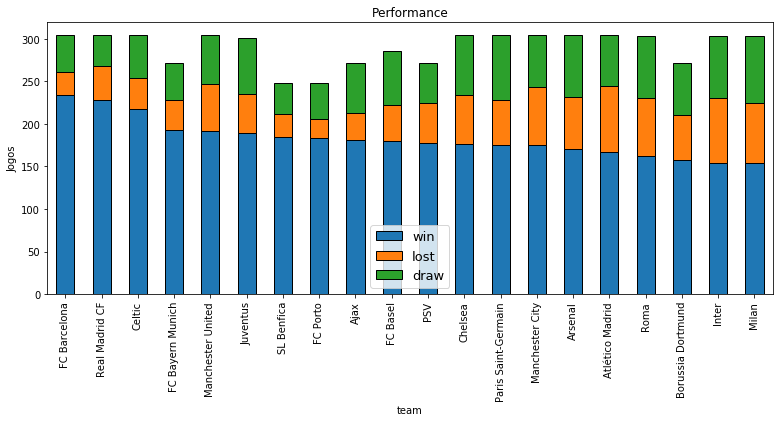

In [350]:
f_new[["win","lost","draw"]][:20].plot(kind = "bar",figsize=(13,5),
                                   stacked =True,linewidth = 1,
                                   edgecolor = "k"*20
                                  )

plt.legend(loc="best",prop = {"size" : 13})
plt.title("Performance")
plt.ylabel("Jogos")
plt.show()

In [13]:
f_new[["win","lost","draw"]][:20]

,win,lost,draw
team,,,
FC Barcelona,234,27,43
Real Madrid CF,228,40,36
Celtic,218,36,50
FC Bayern Munich,193,35,44
Manchester United,192,55,57
Juventus,189,46,66
SL Benfica,185,27,36
FC Porto,183,23,42
Ajax,181,32,59


In [14]:
f['lost'].mean()

65.48310810810811

### Plot de Area por atributo dos jogos

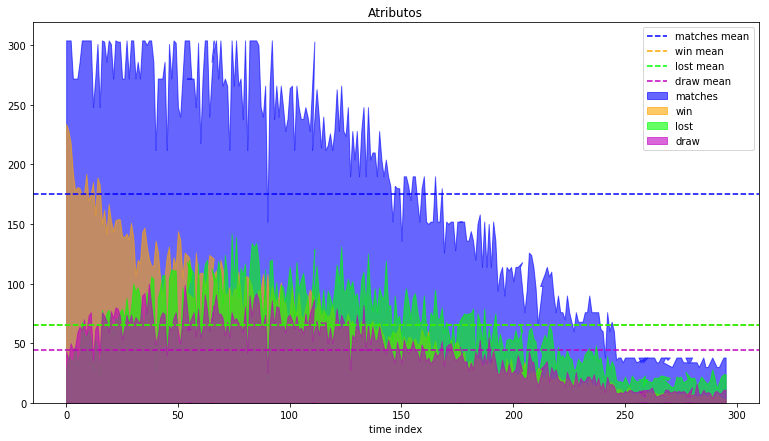

In [22]:
plt.figure(figsize=(13,7))
cols = ["matches","win","lost","draw"]
c    = ["b","orange","lime","m"]
length = len(cols)
for i,j,k in itertools.zip_longest(cols,range(length),c):
    plt.stackplot(f.index,f[i],alpha=.6,color = k,labels=[i])
    plt.axhline(f[i].mean(),color=k,
                linestyle="dashed",label=i+ " mean") # Observar a construção da legenda
    plt.legend(loc="best")
    plt.title("Atributos")
    plt.xlabel("time index")

plt.show() 

### Melhores Times Por Liga

In [12]:
g = data.groupby(["home_team_lname","league"]).agg({"match_api_id":"count","home_team_goal":"sum"}).reset_index()
l = data.groupby(["away_team_lname","league"]).agg({"match_api_id":"count","away_team_goal":"sum"}).reset_index()
g = g.rename(columns={'home_team_lname':"team", 'match_api_id':"matches", 'home_team_goal':"goals"})
l = l.rename(columns={'away_team_lname':"team", 'match_api_id':"matches", 'away_team_goal':"goals"})
gl = pd.concat([g,l])
gl = gl.groupby(["team","league"])[["matches","goals"]].sum().reset_index()
gl = gl.sort_values(by="goals",ascending=False)

x = pd.DataFrame(data.groupby(["league","win"]).agg({"win":"count"}, {"match_api_id":"count"}))
x = x.rename(columns={"win":"team"}).reset_index()
x = x.rename(columns={"win":"team","team":"win"})
x = x.sort_values(by="win",ascending=False)
x = x[x["team"] != "DRAW"]
x = x.drop_duplicates(subset=["league"],keep="first")

a = gl.merge(x,left_on="team",right_on="team",how ="right")
a = a.drop('league_y', 1)
a = a.drop('goals', 1)
a = a.rename(columns={"league_x":"league"})

In [24]:
a

,team,league,matches,win
0,FC Barcelona,Spain LIGA BBVA,304,234
1,Celtic,Scotland Premier League,304,218
2,FC Bayern Munich,Germany 1. Bundesliga,272,193
3,Ajax,Netherlands Eredivisie,272,181
4,FC Basel,Switzerland Super League,286,180
5,Manchester United,England Premier League,304,192
6,Paris Saint-Germain,France Ligue 1,304,175
7,SL Benfica,Portugal Liga ZON Sagres,248,185
8,Juventus,Italy Serie A,301,189
9,RSC Anderlecht,Belgium Jupiler League,212,136


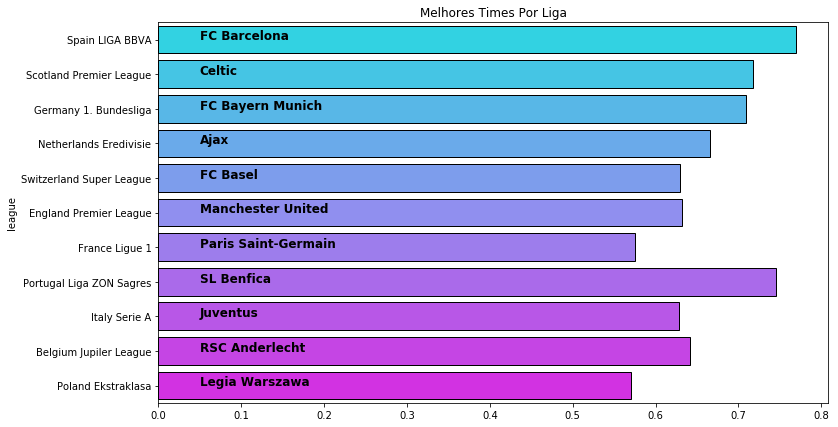

In [25]:
plt.figure(figsize=(12,7))

ax =sns.barplot((a["win"]/a["matches"]),a["league"],palette="cool",
               linewidth = 1 ,edgecolor = "k"*10)

for i,j in enumerate(a["team"]):
    ax.text(.05,i,j,weight = "bold",fontsize = 12)

plt.title("Melhores Times Por Liga")
plt.show()

### Proporção de jogos e gols marcados por liga

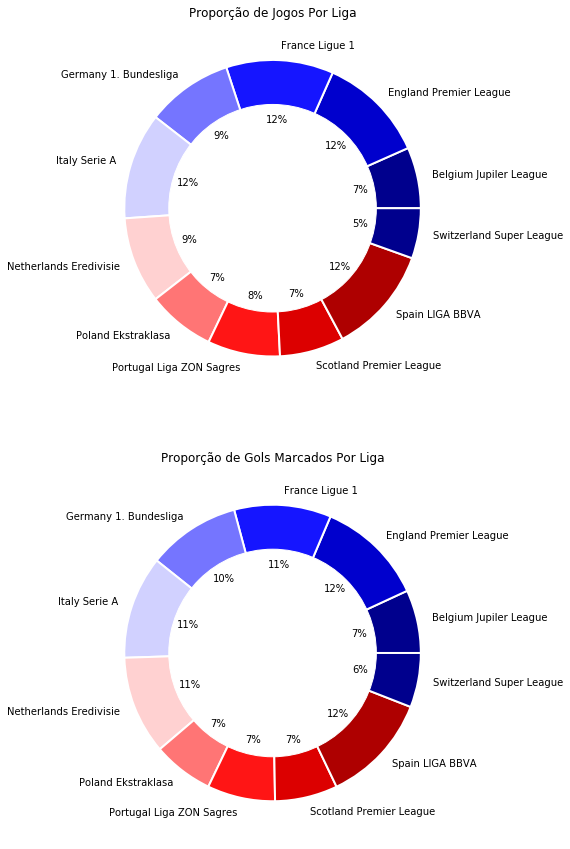

In [27]:
plt.figure(figsize=(7,15))
plt.subplot(211)
agg = data.groupby(["league"]).agg({"match_api_id":"count","total_goal":"sum"})

agg["match_api_id"].plot.pie(colors=sns.color_palette("seismic",10),
                             autopct="%1.0f%%",
                             wedgeprops={"linewidth":2,"edgecolor":"white"})

plt.ylabel("")
my_circ = plt.Circle((0,0),.7,color ="white")
plt.gca().add_artist(my_circ)
plt.title("Proporção de Jogos Por Liga")

plt.subplot(212)
agg["total_goal"].plot.pie(colors=sns.color_palette("seismic",10),
                           autopct="%1.0f%%",
                           wedgeprops={"linewidth":2,"edgecolor":"white"})

plt.ylabel("")
my_circ = plt.Circle((0,0),.7,color ="white")
plt.gca().add_artist(my_circ)
plt.title("Proporção de Gols Marcados Por Liga")
plt.show()

### Melhores Times

Iremos utilizar o WordCloud para construir núvens de palavras

``pip install wordcloud``

In [13]:
from wordcloud import WordCloud

In [14]:
wrd = data[data["win"] != "DRAW"]["win"].to_frame()

In [18]:
wrd

,win
2,RSC Anderlecht
3,KAA Gent
4,Standard de Liège
7,Royal Excel Mouscron
8,KVC Westerlo
...,...
25973,FC Sion
25974,FC St. Gallen
25975,FC Luzern
25976,Grasshopper Club Zürich


In [19]:
wrd["win"].value_counts()[wrd["win"].value_counts() > 100].keys().str.replace(" ","")

Index(['FCBarcelona', 'RealMadridCF', 'Celtic', 'FCBayernMunich',
       'ManchesterUnited', 'Juventus', 'SLBenfica', 'FCPorto', 'Ajax',
       'FCBasel', 'PSV', 'Chelsea', 'ManchesterCity', 'ParisSaint-Germain',
       'Arsenal', 'AtléticoMadrid', 'Roma', 'BorussiaDortmund', 'Inter',
       'Milan', 'OlympiqueLyonnais', 'Napoli', 'TottenhamHotspur', 'Liverpool',
       'LOSCLille', 'FCTwente', 'SportingCP', 'OlympiquedeMarseille',
       'BSCYoungBoys', 'ValenciaCF', 'AZ', 'Feyenoord', 'SevillaFC',
       'Bayer04Leverkusen', 'LegiaWarszawa', 'RSCAnderlecht', 'Fiorentina',
       'Lazio', 'FCSchalke04', 'GirondinsdeBordeaux', 'SCBraga', 'LechPoznań',
       'ClubBruggeKV', 'Motherwell', 'AthleticClubdeBilbao', 'Everton',
       'ASSaint-Étienne', 'Aberdeen', 'FCZürich', 'VfLWolfsburg', 'Udinese',
       'GrasshopperClubZürich', 'DundeeUnited', 'VillarrealCF',
       'StadeRennaisFC', 'MontpellierHéraultSC', 'KAAGent',
       'BorussiaMönchengladbach', 'FCGroningen', 'Rangers', 'WisłaK

In [15]:
wrd = wrd["win"].value_counts()[wrd["win"].value_counts() > 100].keys().str.replace(" ","")

In [21]:
wrd[0]

'FCBarcelona'

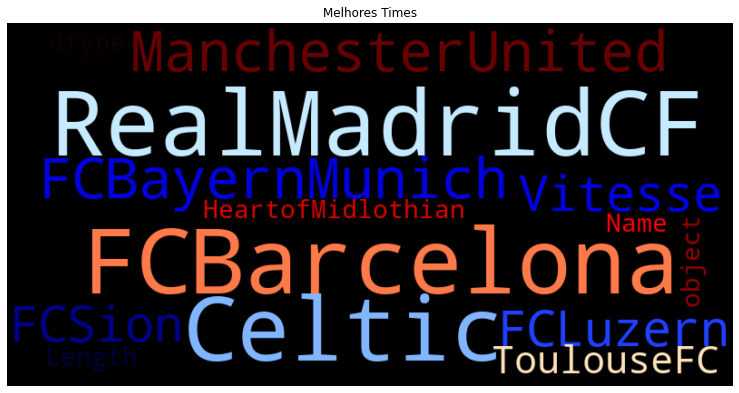

In [16]:
wrd = pd.DataFrame(wrd)
wc = WordCloud(background_color="black",max_font_size=50, max_words=100,scale =2,colormap="flag").generate(str(wrd[0]))
plt.figure(figsize=(13,8))
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.title("Melhores Times")
plt.show()

### Gols em Casa, Por Melhores Times, Por Temporada

In [47]:
list(data)

['country_id',
 'league_id',
 'season',
 'stage',
 'date',
 'match_api_id',
 'home_team_api_id',
 'away_team_api_id',
 'home_team_goal',
 'away_team_goal',
 'country',
 'league',
 '_merge',
 'year',
 'home_team_lname',
 'home_team_sname',
 'away_team_lname',
 'away_team_sname',
 'total_goal',
 'win',
 'outcome_side',
 'lost']

In [38]:
data["win"].value_counts()[1:25]

FC Barcelona           234
Real Madrid CF         228
Celtic                 218
FC Bayern Munich       193
Manchester United      192
Juventus               189
SL Benfica             185
FC Porto               183
Ajax                   181
FC Basel               180
PSV                    178
Chelsea                176
Manchester City        175
Paris Saint-Germain    175
Arsenal                170
Atlético Madrid        167
Roma                   162
Borussia Dortmund      157
Inter                  154
Milan                  154
Olympique Lyonnais     153
Napoli                 153
Tottenham Hotspur      151
Liverpool              150
Name: win, dtype: int64

In [19]:
i = data["win"].value_counts()[1:25].index
t= pd.pivot_table(index="home_team_lname",columns="season",values="home_team_goal",
                  data=data,aggfunc="sum") # Criar uma tabela

In [22]:
t

season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
home_team_lname,,,,,,,,
1. FC Kaiserslautern,NaN,NaN,25.0,12.0,NaN,NaN,NaN,NaN
1. FC Köln,14.0,18.0,30.0,20.0,NaN,NaN,18.0,16.0
1. FC Nürnberg,NaN,18.0,28.0,22.0,24.0,16.0,NaN,NaN
1. FSV Mainz 05,NaN,22.0,22.0,27.0,22.0,28.0,27.0,23.0
AC Ajaccio,NaN,NaN,NaN,22.0,19.0,23.0,NaN,NaN
...,...,...,...,...,...,...,...,...
Xerez Club Deportivo,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN
Zagłębie Lubin,NaN,14.0,14.0,18.0,24.0,23.0,NaN,23.0
Zawisza Bydgoszcz,NaN,NaN,NaN,NaN,NaN,27.0,16.0,NaN


In [39]:
t[t.index.isin(i)]

season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
home_team_lname,,,,,,,,
Ajax,41.0,64.0,38.0,49.0,40.0,42.0,37.0,49.0
Arsenal,31.0,48.0,33.0,39.0,47.0,36.0,41.0,31.0
Atlético Madrid,47.0,37.0,35.0,36.0,42.0,49.0,42.0,33.0
Borussia Dortmund,34.0,29.0,35.0,44.0,40.0,41.0,26.0,49.0
Celtic,48.0,42.0,51.0,41.0,52.0,50.0,50.0,55.0
Chelsea,33.0,68.0,39.0,41.0,41.0,43.0,36.0,32.0
FC Barcelona,61.0,57.0,46.0,73.0,63.0,64.0,64.0,67.0
FC Basel,39.0,54.0,43.0,44.0,36.0,41.0,43.0,44.0
FC Bayern Munich,45.0,39.0,48.0,49.0,56.0,48.0,46.0,51.0


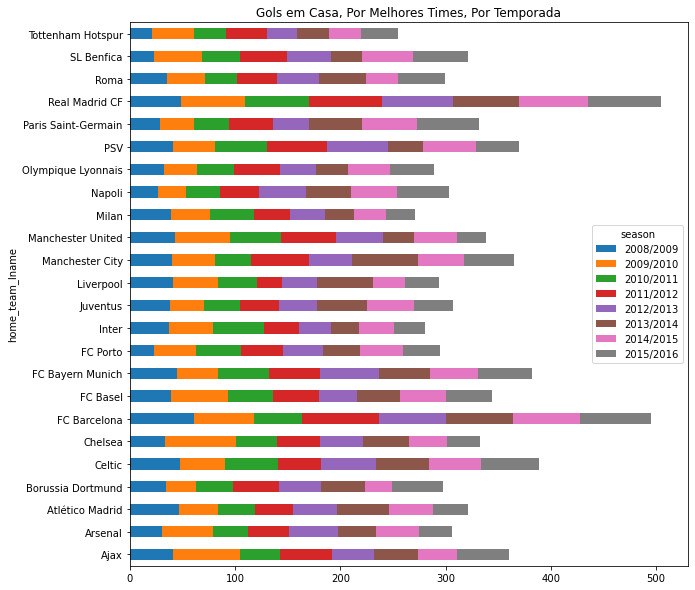

In [27]:
t=t[t.index.isin(i)]
t.plot(kind="barh",stacked=True,figsize=(10,10))
plt.title("Gols em Casa, Por Melhores Times, Por Temporada")
plt.show()

Criar uma tabela como (excel) em DataFrame

In [28]:
t= pd.pivot_table(index="home_team_lname",columns="season",values="home_team_goal",
                  data=data,aggfunc="sum")

In [29]:
t

season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
home_team_lname,,,,,,,,
1. FC Kaiserslautern,NaN,NaN,25.0,12.0,NaN,NaN,NaN,NaN
1. FC Köln,14.0,18.0,30.0,20.0,NaN,NaN,18.0,16.0
1. FC Nürnberg,NaN,18.0,28.0,22.0,24.0,16.0,NaN,NaN
1. FSV Mainz 05,NaN,22.0,22.0,27.0,22.0,28.0,27.0,23.0
AC Ajaccio,NaN,NaN,NaN,22.0,19.0,23.0,NaN,NaN
...,...,...,...,...,...,...,...,...
Xerez Club Deportivo,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN
Zagłębie Lubin,NaN,14.0,14.0,18.0,24.0,23.0,NaN,23.0
Zawisza Bydgoszcz,NaN,NaN,NaN,NaN,NaN,27.0,16.0,NaN


### Jogos entre os Melhores Times

annot : bool or rectangular dataset, optional

If True, write the data value in each cell. If an array-like with the same shape as data, then use this to annotate the heatmap instead of the raw data.

In [40]:
i = data["win"].value_counts()[1:50].index
c = data[(data["home_team_lname"].isin(i)) & (data["away_team_lname"].isin(i))]
d = pd.crosstab(c["home_team_lname"],c["away_team_lname"])

In [41]:
d

away_team_lname,AS Saint-Étienne,AZ,Aberdeen,Ajax,Arsenal,Athletic Club de Bilbao,Atlético Madrid,BSC Young Boys,Bayer 04 Leverkusen,Borussia Dortmund,...,Paris Saint-Germain,RSC Anderlecht,Real Madrid CF,Roma,SC Braga,SL Benfica,Sevilla FC,Sporting CP,Tottenham Hotspur,Valencia CF
home_team_lname,,,,,,,,,,,,,,,,,,,,,
AS Saint-Étienne,0,0,0,0,0,0,0,0,0,0,...,8,0,0,0,0,0,0,0,0,0
AZ,0,0,0,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aberdeen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ajax,0,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arsenal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,0
Athletic Club de Bilbao,0,0,0,0,0,0,8,0,0,0,...,0,0,8,0,0,0,8,0,0,8
Atlético Madrid,0,0,0,0,0,8,0,0,0,0,...,0,0,8,0,0,0,8,0,0,8
BSC Young Boys,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bayer 04 Leverkusen,0,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0


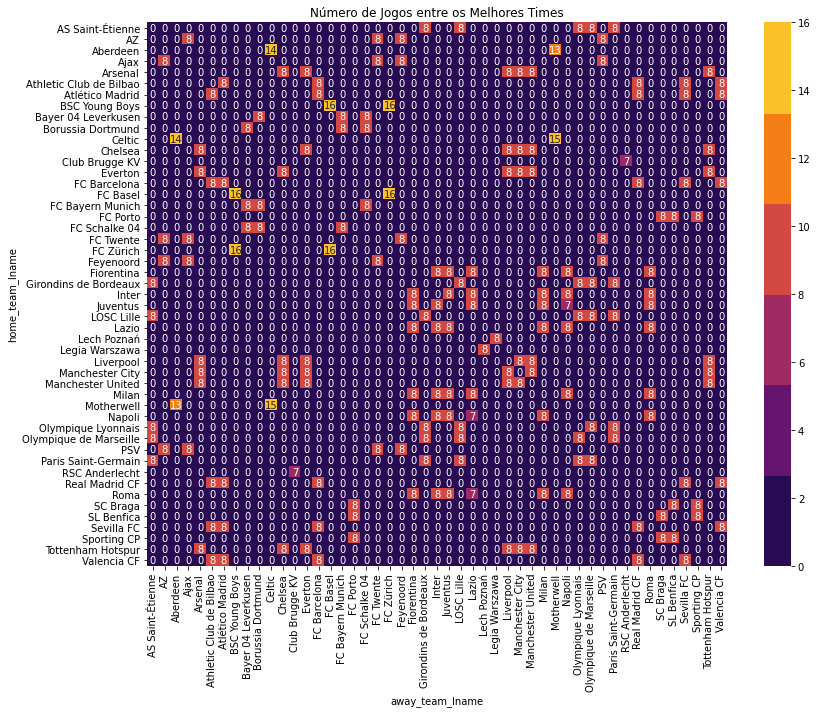

In [43]:
i = data["win"].value_counts()[1:50].index
c = data[(data["home_team_lname"].isin(i)) & (data["away_team_lname"].isin(i))]
d = pd.crosstab(c["home_team_lname"],c["away_team_lname"])
plt.figure(figsize=(13,10))
sns.heatmap(d,annot=True,cmap=sns.color_palette("inferno")) # Opção annot
plt.title("Número de Jogos entre os Melhores Times")
plt.show()

In [31]:
d = pd.crosstab(c["home_team_lname"],c["away_team_lname"])

In [32]:
d

away_team_lname,AS Saint-Étienne,AZ,Aberdeen,Ajax,Arsenal,Athletic Club de Bilbao,Atlético Madrid,BSC Young Boys,Bayer 04 Leverkusen,Borussia Dortmund,...,Paris Saint-Germain,RSC Anderlecht,Real Madrid CF,Roma,SC Braga,SL Benfica,Sevilla FC,Sporting CP,Tottenham Hotspur,Valencia CF
home_team_lname,,,,,,,,,,,,,,,,,,,,,
AS Saint-Étienne,0,0,0,0,0,0,0,0,0,0,...,8,0,0,0,0,0,0,0,0,0
AZ,0,0,0,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aberdeen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ajax,0,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arsenal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,0
Athletic Club de Bilbao,0,0,0,0,0,0,8,0,0,0,...,0,0,8,0,0,0,8,0,0,8
Atlético Madrid,0,0,0,0,0,8,0,0,0,0,...,0,0,8,0,0,0,8,0,0,8
BSC Young Boys,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bayer 04 Leverkusen,0,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0


### Gols Marcados Por Liga

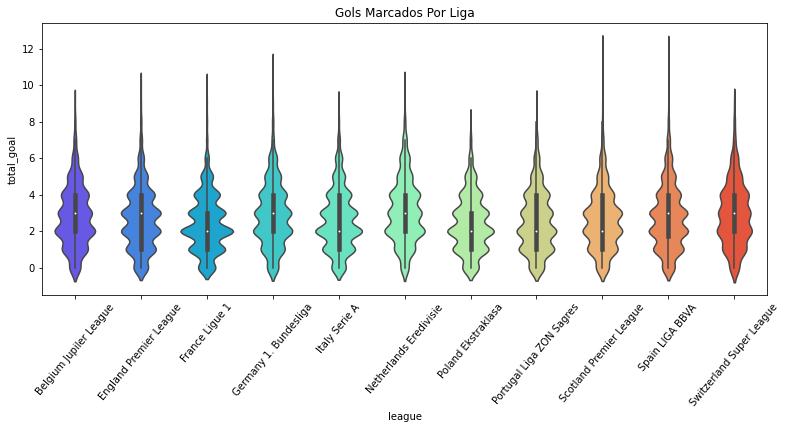

In [46]:
plt.figure(figsize=(13,5))
sns.violinplot(data["league"],data["total_goal"],palette="rainbow")
plt.title("Gols Marcados Por Liga")
plt.xticks(rotation = 50)
plt.show()

### Atributos dos Jogadores

In [48]:
player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [55]:
player["weight_kg"] = player["weight"] * 0.453592
player["height_m"]  = player["height"] / 100
player["bmi"]       = player["weight_kg"]/(player["height_m"] * player["height_m"])
player["year"]  = pd.DatetimeIndex(player["birthday"]).year
player["age"]   = 2021 - player["year"]

In [56]:
player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,weight_kg,height_m,bmi,year,age
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,84.821704,1.8288,25.361478,1992,29
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,66.224432,1.7018,22.866579,1989,32
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163,73.935496,1.7018,25.529126,1991,30
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198,89.811216,1.8288,26.853330,1982,39
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154,69.853168,1.8288,20.885923,1979,42


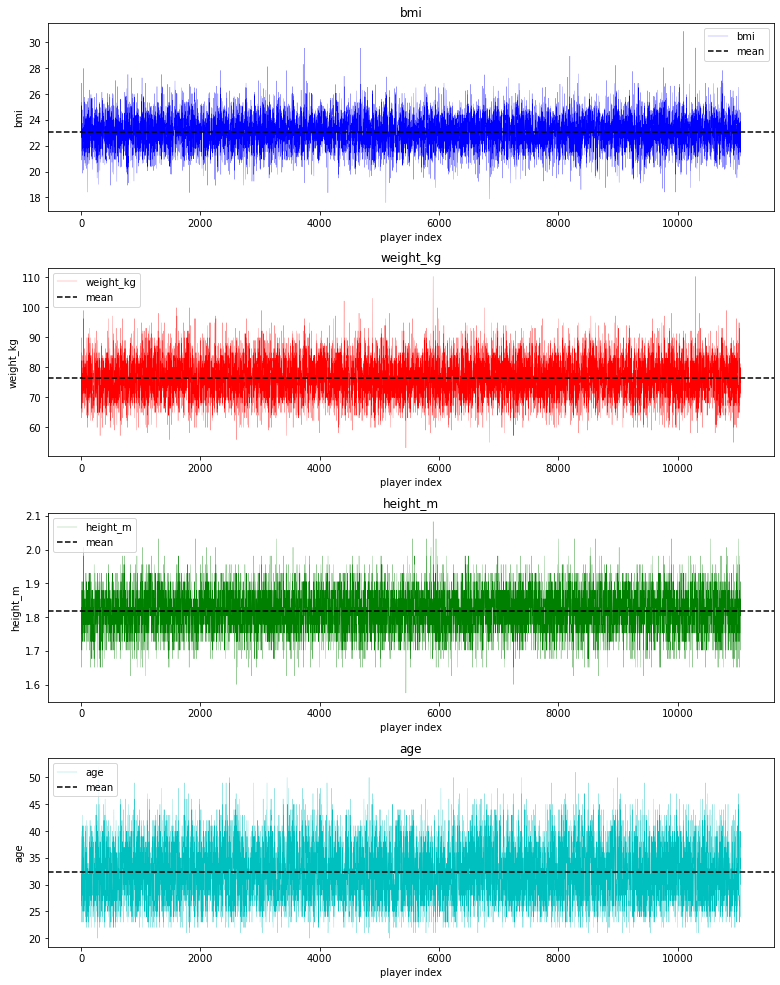

In [58]:
player["weight_kg"] = player["weight"] * 0.453592
player["height_m"]  = player["height"] / 100
player["bmi"]       = player["weight_kg"]/(player["height_m"] * player["height_m"])
player["year"]  = pd.DatetimeIndex(player["birthday"]).year
player["age"]   = 2019 - player["year"]

cols  = ["bmi","weight_kg","height_m","age"]
length = len(cols)
c = ["b","r","g","c"]
plt.figure(figsize=(13,17))

for i,j,k in itertools.zip_longest(cols,range(length),c):
    plt.subplot(4,1,j+1)
    player[i].plot(color = k ,linewidth =.2,label = i)
    plt.axhline(player[i].mean(),color = "k",linestyle = "dashed",label="mean")
    plt.legend(loc="best")
    plt.subplots_adjust(hspace = .3)
    plt.xlabel("player index")
    plt.ylabel(i)
    plt.title(i)

plt.show()

In [59]:
l = [1,2,3,4,5]

In [68]:
len(l)

5

In [73]:
l[4]

5

In [85]:
l[-4:]

[2, 3, 4, 5]

### Atributos dos Jogadores Normalmente Distribuidos

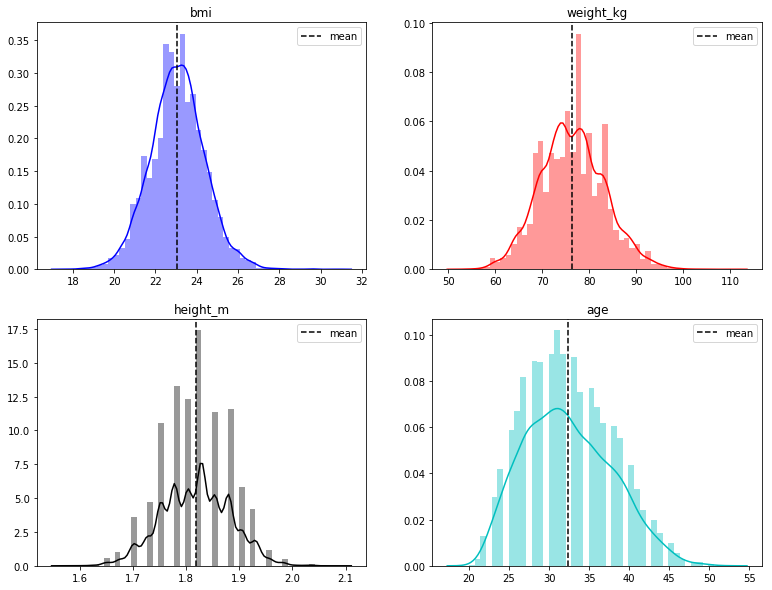

In [65]:
cols  = ["bmi","weight_kg","height_m","age"]
length = len(cols)
c = ["b","r","k","c"]
plt.figure(figsize=(13,10))

for i,j,k in itertools.zip_longest(cols,range(length),c):
    plt.subplot(2,2,j+1)
    sns.distplot(player[i],color=k)
    plt.axvline(player[i].mean(),color = "k",linestyle = "dashed",label="mean")
    plt.legend(loc="best")
    plt.title(i)
    plt.xlabel("")

plt.show()

In [94]:
player.loc[player["age"].idxmax()]["player_name"]

'Alberto Fontana'

In [95]:
print ("Atributos Jogadores")
print ("===================================================================================================")
print ("Jogador mais velho é",player.loc[player["age"].idxmax()]["player_name"],"com idade de",player["age"].max(),"anos")
print ("Jogadores mais novos são",list(player[player["age"]==20]["player_name"]),"com idades de",player["age"].min(),"anos")
print ("Jogador mais alto é",player.loc[player["height_m"].idxmax()]["player_name"],"com altura de",player["height_m"].max(),"metros")
print ("Jogador mais baixo é",player.loc[player["height_m"].idxmin()]["player_name"],"com altura de",player["height_m"].min(),"metros")
print ("Jogador com maior peso é",list(player[player["weight_kg"] == 110.222856]["player_name"]),"com peso de ",player["weight_kg"].max(),"kg")
print ("Jogador com menor peso é",player.loc[player["weight_kg"].idxmin()]["player_name"],"com peso de ",player["weight_kg"].min(),"kg")
print ("Jogador com o maior BMI é",player.loc[player["bmi"].idxmax()]["player_name"],"com",player["bmi"].max(),"kg/m2")
print ("Jogador com o menor BMI é",player.loc[player["bmi"].idxmin()]["player_name"],"com",player["bmi"].min(),"kg/m2")

Atributos Jogadores
Jogador mais velho é Alberto Fontana com idade de 52 anos
Jogadores mais novos são ['Alban Lafont', 'Gianluigi Donnarumma', 'Jonathan Leko'] com idades de 20 anos
Jogador mais alto é Kristof van Hout com altura de 2.0828 metros
Jogador mais baixo é Juan Quero com altura de 1.5748 metros
Jogador com maior peso é ['Kristof van Hout', 'Tim Wiese'] com peso de  110.222856 kg
Jogador com menor peso é Juan Quero com peso de  53.070264 kg
Jogador com o maior BMI é Sylvan Ebanks-Blake com 30.865702475349586 kg/m2
Jogador com o menor BMI é John Stewart com 17.58956425144406 kg/m2


In [99]:
player[["height","weight_kg","age","bmi"]].describe()[1:].transpose()

,mean,std,min,25%,50%,75%,max
height,181.867445,6.369201,157.480000,177.800000,182.880000,185.420000,208.280000
weight_kg,76.375952,6.799443,53.070264,72.121128,76.203456,81.192968,110.222856
age,32.357143,5.481362,20.000000,28.000000,32.000000,36.000000,52.000000
bmi,23.065734,1.317103,17.589564,22.174718,23.055889,23.871504,30.865702


### Sumário dos Atributos

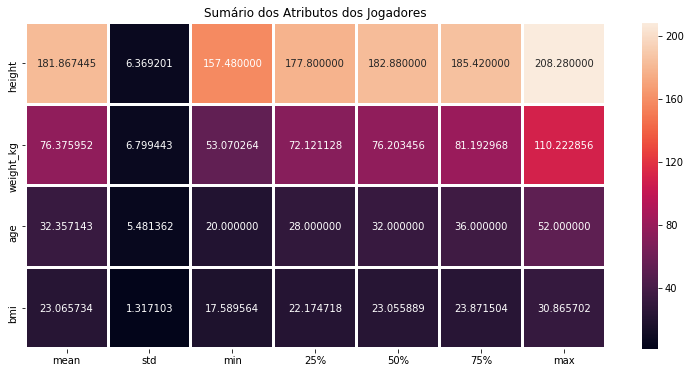

In [72]:
plt.figure(figsize=(13,6))
sns.heatmap(player[["height","weight_kg","age","bmi"]].describe()[1:].transpose(),annot=True,fmt="f",linecolor="white",linewidths=2) # fmt: String formatting code to use when adding annotations
plt.title("Sumário dos Atributos dos Jogadores")
plt.show()

### Correlação Entre as Variáveis

In [101]:
player.corr()

,id,player_api_id,player_fifa_api_id,height,weight,weight_kg,height_m,bmi,year,age
id,1.000000,-0.006515,-0.002377,0.008563,0.004654,0.004654,0.008563,-0.002845,0.000653,-0.000653
player_api_id,-0.006515,1.000000,0.576963,-0.053595,-0.164771,-0.164771,-0.053595,-0.192010,0.754425,-0.754425
player_fifa_api_id,-0.002377,0.576963,1.000000,-0.025890,-0.111867,-0.111867,-0.025890,-0.142558,0.789524,-0.789524
height,0.008563,-0.053595,-0.025890,1.000000,0.766626,0.766626,1.000000,-0.030688,-0.061700,0.061700
weight,0.004654,-0.164771,-0.111867,0.766626,1.000000,1.000000,0.766626,0.616426,-0.177416,0.177416
weight_kg,0.004654,-0.164771,-0.111867,0.766626,1.000000,1.000000,0.766626,0.616426,-0.177416,0.177416
height_m,0.008563,-0.053595,-0.025890,1.000000,0.766626,0.766626,1.000000,-0.030688,-0.061700,0.061700
bmi,-0.002845,-0.192010,-0.142558,-0.030688,0.616426,0.616426,-0.030688,1.000000,-0.200625,0.200625
year,0.000653,0.754425,0.789524,-0.061700,-0.177416,-0.177416,-0.061700,-0.200625,1.000000,-1.000000
age,-0.000653,-0.754425,-0.789524,0.061700,0.177416,0.177416,0.061700,0.200625,-1.000000,1.000000


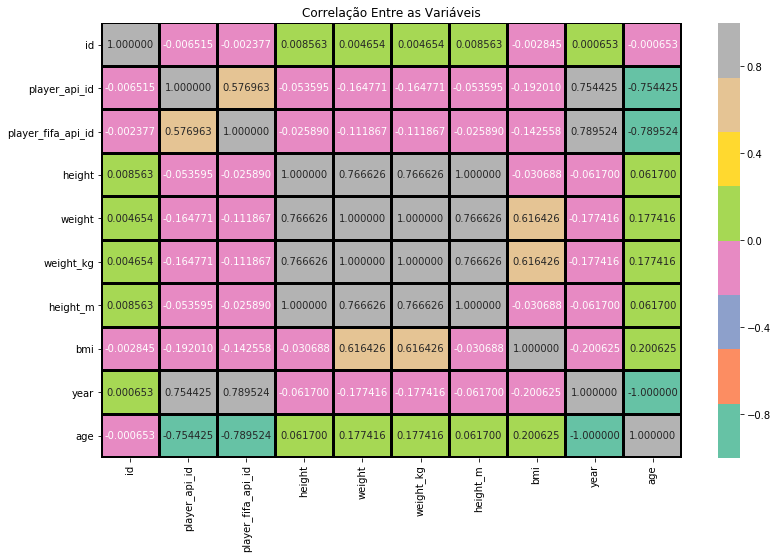

In [73]:
correlation = player.corr()
plt.figure(figsize=(13,8))
sns.heatmap(correlation,annot=True,fmt="f",linecolor="k",
            linewidths=2,cmap =sns.color_palette("Set2"))
plt.title("Correlação Entre as Variáveis")
plt.show()

### Densidade Entre Altura e Peso

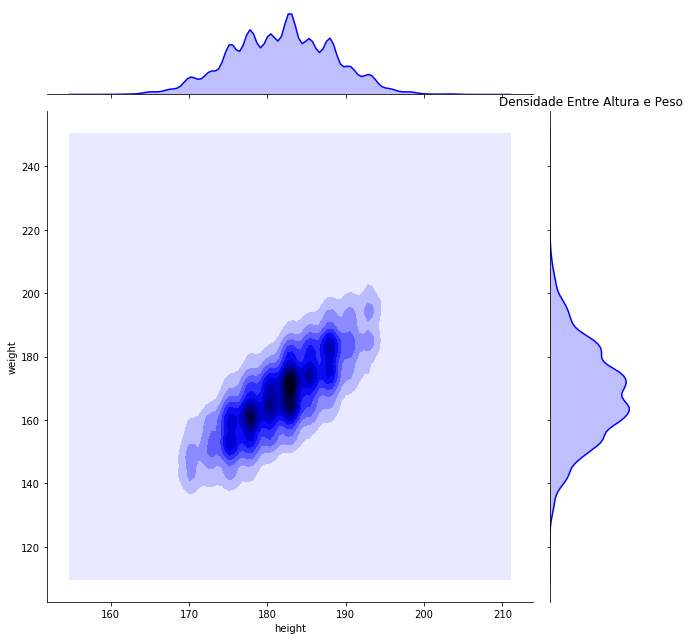

In [75]:
sns.jointplot(player["height"],player["weight"],kind="kde",color="b",size = 9)
plt.title("Densidade Entre Altura e Peso")
plt.show()

### Hexbin para Idade vs. peso, altura e BMI

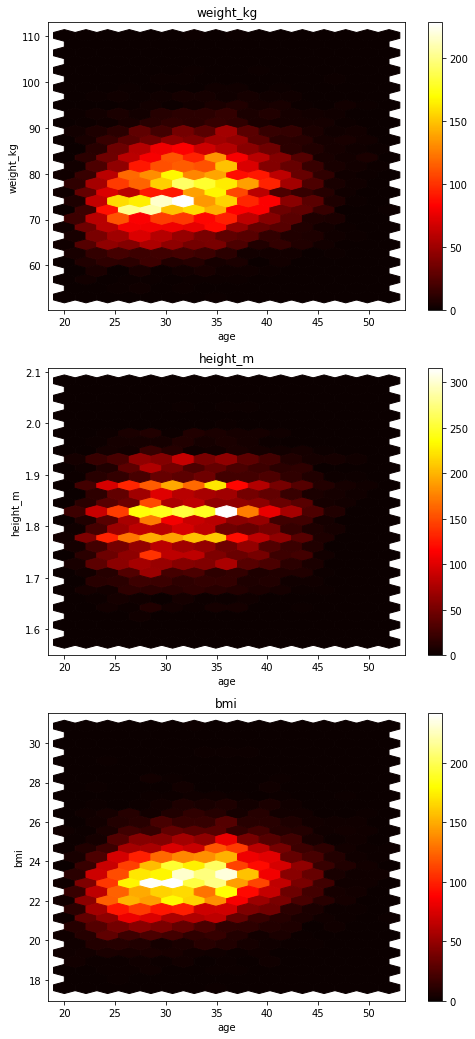

In [76]:
cols = [ 'weight_kg', 'height_m', 'bmi']
length=len(cols)
plt.figure(figsize=(8,18))
for i,j in itertools.zip_longest(cols,range(length)):
    plt.subplot(3,1,j+1)
    plt.hexbin(player["age"],player[i],cmap="hot",gridsize=(15,15))
    plt.xlabel("age")
    plt.ylabel(i)
    plt.colorbar()
    plt.title(i)

plt.show()

### Tendências Das Primeiras Letras nos Nomes dos Jogadores

In [113]:
player["player_name"].str.split(" ").str[0].str.upper().str[:1].value_counts()

M    1310
J    1082
A    1069
D     812
S     761
R     672
C     541
L     486
G     483
F     456
P     452
B     404
K     376
T     374
E     322
N     321
I     206
H     199
V     182
O     151
W     135
Y     130
Z      70
U      31
X      23
Q      12
Name: player_name, dtype: int64

In [388]:
player["fl"] = player["player_name"].str.split(" ").str[0].str.upper().str[:1]

In [390]:
player[player["fl"] == 'M']

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,fl
6436,6445,41463,Maarten Martens,156544,1984-07-02 00:00:00,175.26,146,M
6437,6446,30841,Maarten Stekelenburg,2147,1982-09-22 00:00:00,198.12,203,M
6438,6447,140951,Macedo Novaes,188272,1983-03-30 00:00:00,182.88,174,M
6439,6448,26628,Maceo Rigters,163884,1984-01-22 00:00:00,177.80,183,M
6440,6449,118822,Maciej Dabrowski,187982,1987-04-20 00:00:00,193.04,194,M
6441,6450,361714,Maciej Gajos,210000,1991-03-19 00:00:00,175.26,143,M
6442,6451,69594,Maciej Gostomski,176384,1988-09-27 00:00:00,195.58,198,M
6443,6452,69346,Maciej Iwanski,105898,1981-05-07 00:00:00,170.18,154,M
6444,6453,206844,Maciej Jankowski,200086,1990-01-04 00:00:00,180.34,152,M
6445,6454,13383,Maciej Korzym,157698,1988-05-02 00:00:00,180.34,170,M


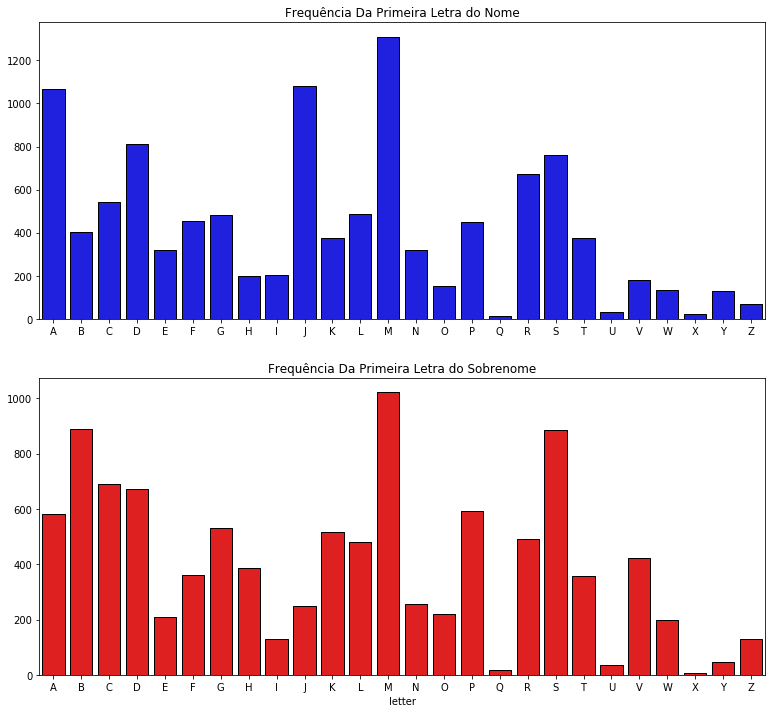

In [78]:
first = pd.DataFrame(player["player_name"].str.split(" ").str[0].str.upper().str[:1].value_counts())
last = pd.DataFrame(player["player_name"].str.split(" ").str[1].str.upper().str[:1].value_counts())
lets = first.merge(last,left_index=True,right_index=True,how="left").reset_index()
lets = lets.rename(columns={"index":"letter","player_name_x":'first_name',"player_name_y":"last_name"}).sort_values(by="letter",ascending = True)

plt.figure(figsize=(13,12))
plt.subplot(211)
sns.barplot(lets["letter"],lets["first_name"],color="b",
            linewidth = 1,edgecolor = "k"*26)

plt.ylabel("")
plt.xlabel("")
plt.title("Frequência Da Primeira Letra do Nome")
plt.subplot(212)
sns.barplot(lets["letter"],lets["last_name"],color="r",
            linewidth = 1,edgecolor = "k"*26)

plt.ylabel("")
plt.title("Frequência Da Primeira Letra do Sobrenome")
plt.show()

Juntar dados dos Jogadores com seus Atributos

In [116]:
player_attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [117]:
player_info = player_attributes.merge(player,left_on="player_api_id",right_on="player_api_id",how="left")

i =["id_x","id_y",'player_fifa_api_id_y','height', 'weight', 'weight_kg', 'height_m', 'bmi', 'year','age','birthday', 'fl']
player_info = player_info[[x for x in player_info.columns if x not in i]]
player_info.columns

player_info["date"] = pd.to_datetime(player_info["date"],format="%Y-%m-%d")

In [118]:
player_info

,player_fifa_api_id_x,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name
0,218353,505942,2016-02-18,67.0,71.0,right,medium,medium,49.0,44.0,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye
1,218353,505942,2015-11-19,67.0,71.0,right,medium,medium,49.0,44.0,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye
2,218353,505942,2015-09-21,62.0,66.0,right,medium,medium,49.0,44.0,...,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye
3,218353,505942,2015-03-20,61.0,65.0,right,medium,medium,48.0,43.0,...,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,Aaron Appindangoye
4,218353,505942,2007-02-22,61.0,65.0,right,medium,medium,48.0,43.0,...,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,Aaron Appindangoye
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,102359,39902,2009-08-30,83.0,85.0,right,medium,low,84.0,77.0,...,83.0,22.0,31.0,30.0,9.0,20.0,84.0,20.0,20.0,Zvjezdan Misimovic
183974,102359,39902,2009-02-22,78.0,80.0,right,medium,low,74.0,76.0,...,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0,Zvjezdan Misimovic
183975,102359,39902,2008-08-30,77.0,80.0,right,medium,low,74.0,71.0,...,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0,Zvjezdan Misimovic
183976,102359,39902,2007-08-30,78.0,81.0,right,medium,low,74.0,64.0,...,53.0,28.0,32.0,30.0,9.0,20.0,73.0,20.0,20.0,Zvjezdan Misimovic


In [398]:
player_info["player_name"].value_counts().sort_values()[-20:]

Roberto Pereyra     56
Alessio Cerci       56
Juan                58
David Lopez         60
Paulinho            63
Carlos Eduardo      63
Diego               64
Juan Carlos         65
Marcelo             66
Rafael              67
Scott Brown         71
Maicon              73
Fernando            75
Rafinha             75
Josue               77
Ricardo             84
Felipe              89
Douglas             93
Alex               104
Danilo             108
Name: player_name, dtype: int64

### Jogadores que Jogaram mais Jogos

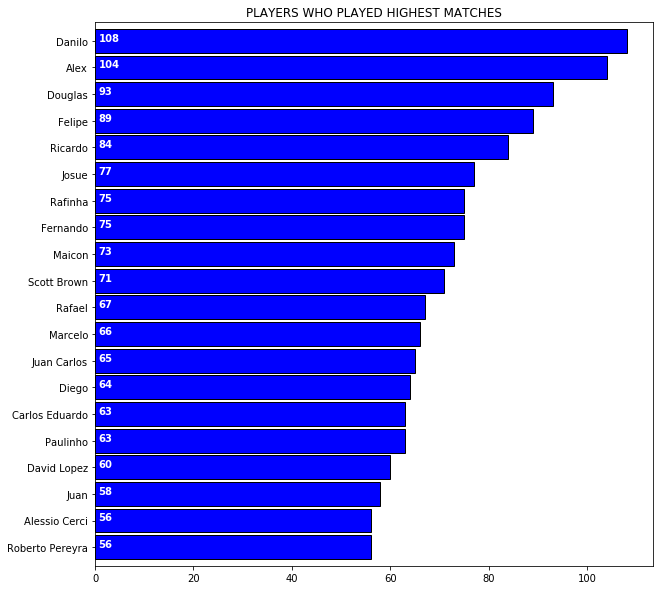

In [80]:
ax = player_info["player_name"].value_counts().sort_values()[-20:].plot(kind="barh",figsize=(10,10),
                                                                        color="b",width=.9,
                                                                        linewidth = 1,edgecolor = "k"*20
                                                                       )

for i,j in enumerate(player_info["player_name"].value_counts().sort_values()[-20:].values):
    ax.text(.7,i,j,weight = "bold",color="white")

ax.set_title("PLAYERS WHO PLAYED HIGHEST MATCHES")
plt.show()

### WordCloud para Nomes dos Jogadores

In [120]:
from PIL import Image

In [121]:
i = Image.open("z.jpg")

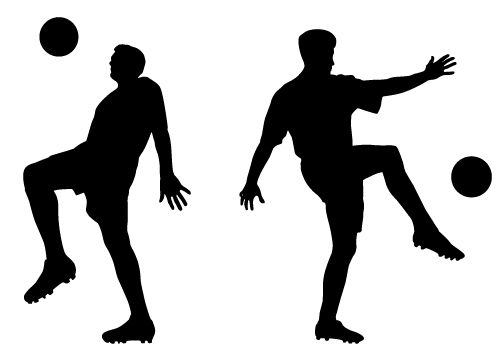

In [123]:
i

In [138]:
im = np.array(i)

In [142]:
im[0][0] = [75, 87,200]

In [143]:
im

array([[[ 75,  87, 200],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

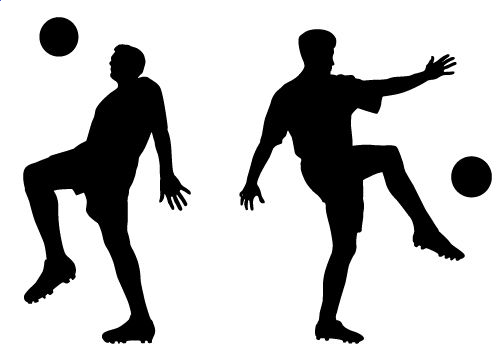

In [144]:
img = Image.fromarray(im, 'RGB')
img

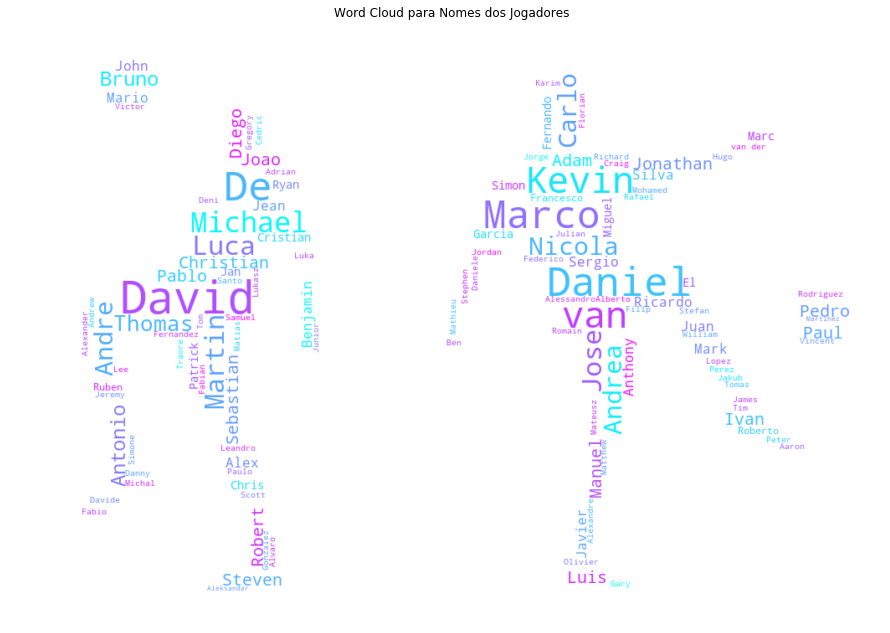

In [95]:
play = player_info["player_name"].unique()
img = np.array(Image.open("z.jpg"))
wc = WordCloud(background_color="white",scale=2,mask=img,colormap="cool",max_words=100000).generate(" ".join(play))
fig = plt.figure(figsize=(15,15))
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud para Nomes dos Jogadores")
plt.show()

In [399]:
img

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [400]:
len(img)

350

In [402]:
len(img[0])

500

In [403]:
img[0][0]

array([255, 255, 255], dtype=uint8)

### Pés Preferidos dos Jogadores

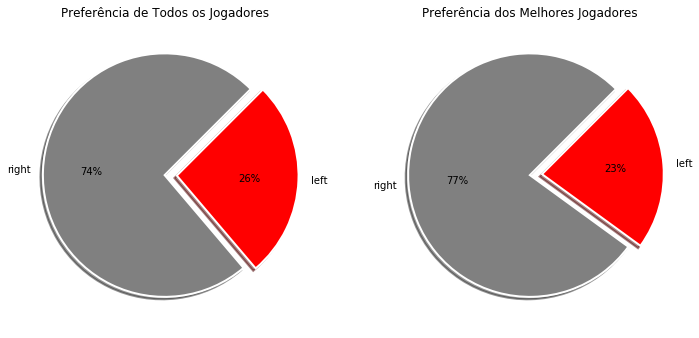

In [105]:
plt.figure(figsize=(12,6))
plt.subplot(121)
pf = player_info.groupby(["player_api_id","preferred_foot"])["overall_rating"].mean().reset_index()["preferred_foot"].value_counts()
pf.plot.pie(autopct = "%1.0f%%",shadow = True,
            wedgeprops={"linewidth":2,"edgecolor":"white"},
            colors=["grey","r"],explode=[0,.1],startangle=45)

plt.title("Preferência de Todos os Jogadores")
plt.ylabel("")

plt.subplot(122)
t_f = player_info.groupby(["player_api_id","preferred_foot"])["overall_rating"].mean().reset_index()
t_f[t_f["overall_rating"] > 80]["preferred_foot"].value_counts().plot.pie(autopct = "%1.0f%%",
                                                                          shadow = True,
                                                                          wedgeprops={"linewidth":2,"edgecolor":"white"},
                                                                          colors=["grey","r"],
                                                                          explode=[0,.1],
                                                                          startangle=45)

plt.title("Preferência dos Melhores Jogadores")
plt.ylabel("")
plt.show()

### Estatísticas dos Melhores Jogadores (rating > 91)

In [145]:
player_info.head()

,player_fifa_api_id_x,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name
0,218353,505942,2016-02-18,67.0,71.0,right,medium,medium,49.0,44.0,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye
1,218353,505942,2015-11-19,67.0,71.0,right,medium,medium,49.0,44.0,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye
2,218353,505942,2015-09-21,62.0,66.0,right,medium,medium,49.0,44.0,...,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye
3,218353,505942,2015-03-20,61.0,65.0,right,medium,medium,48.0,43.0,...,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,Aaron Appindangoye
4,218353,505942,2007-02-22,61.0,65.0,right,medium,medium,48.0,43.0,...,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,Aaron Appindangoye


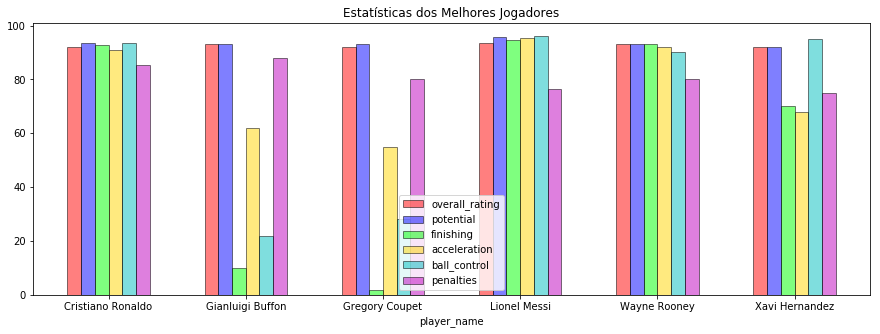

In [107]:
top_rated = player_info[player_info["overall_rating"]  > 91 ]
top_rated = top_rated[['player_name','player_api_id', 'date', 
                       'overall_rating','potential','finishing','acceleration',
                       'ball_control' ,'penalties']]

top_rated = top_rated.groupby("player_name").agg({'overall_rating':"mean",'potential':"mean",
                                                  'finishing':"mean",'acceleration':"mean",
                                                  'ball_control':"mean" ,'penalties':"mean"})

top_rated.plot(kind="bar",width=.6,figsize=(15,5),
               colors=["r","b","lime","gold","c","m"],alpha=.5,
              linewidth = 1,edgecolor = "k"*6)

plt.title("Estatísticas dos Melhores Jogadores")
plt.xticks(rotation = 0)
plt.legend(loc ="lower center")
plt.show()

### Comparador de Jogadores

In [146]:
idx  = "player_api_id"
cols = ['overall_rating','potential', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle']

In [147]:
x1 = player_info[player_info["player_name"] == 'Lionel Messi']
x1 = x1.groupby(["player_name"])[cols].mean()
x1

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle
player_name,,,,,,,,,,,,,,,,,,,,,
Lionel Messi,92.192308,95.230769,83.346154,92.230769,69.269231,88.807692,87.538462,96.461538,87.692308,84.115385,...,59.692308,86.923077,49.269231,34.230769,90.538462,90.269231,80.153846,18.769231,21.846154,20.115385


In [148]:
x2 = player_info[player_info["player_name"] == 'Cristiano Ronaldo']
x2 = x2.groupby(["player_name"])[cols].mean()
x2

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle
player_name,,,,,,,,,,,,,,,,,,,,,
Cristiano Ronaldo,91.28,93.48,83.88,91.12,85.52,82.28,85.56,92.64,88.0,81.64,...,78.68,89.88,61.28,35.64,86.48,80.68,83.6,22.12,30.84,23.0


In [155]:
z = pd.concat([x1,x2]).transpose().reset_index()
z  = z.rename(columns={"index":"attributes"})
z.index = z.attributes
z

player_name,attributes,Lionel Messi,Cristiano Ronaldo
attributes,,,
overall_rating,overall_rating,92.192308,91.28
potential,potential,95.230769,93.48
crossing,crossing,83.346154,83.88
finishing,finishing,92.230769,91.12
heading_accuracy,heading_accuracy,69.269231,85.52
short_passing,short_passing,88.807692,82.28
volleys,volleys,87.538462,85.56
dribbling,dribbling,96.461538,92.64
curve,curve,87.692308,88.00


In [159]:
def player_comparator(player1,player2):
    
    x1 = player_info[player_info["player_name"] == player1]
    x1 = x1.groupby(["player_name"])[cols].mean()
    
    x2 = player_info[player_info["player_name"] == player2]
    x2 = x2.groupby(["player_name"])[cols].mean()
    
    z  = pd.concat([x1,x2]).transpose().reset_index()
    z  = z.rename(columns={"index":"attributes",player1:player1,player2:player2})
    z.index = z.attributes
    z[[player1,player2]].plot(kind = "barh",
                            figsize = (8,12),
                            #colors = ["orange","grey"],
                            linewidth = 1 ,
                            width = .7,
                            edgecolor = ["k"]*z["attributes"].nunique()
                            )
    plt.xlabel("mean value")
    plt.legend(loc = "best",prop = {"size" : 15})
    plt.grid(True,alpha = .3)
    plt.title(player1+"  vs  "+player2)
    plt.show()

### MESSI VS RONALDO

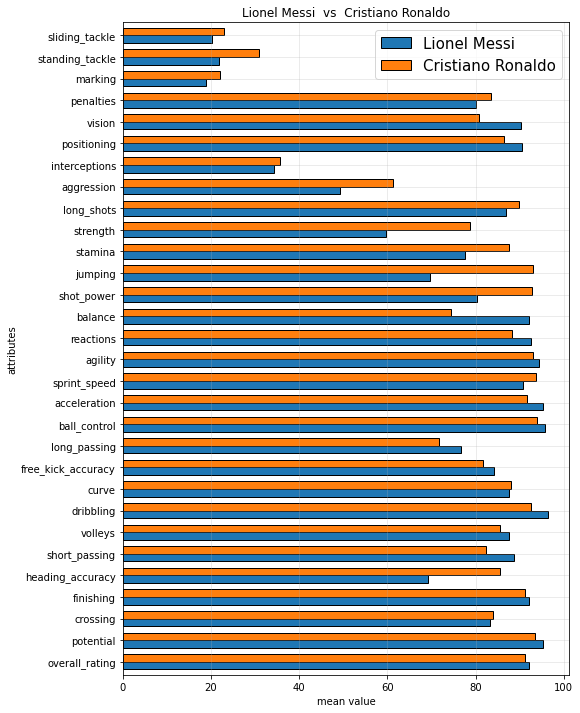

In [160]:
player_comparator('Lionel Messi','Cristiano Ronaldo')

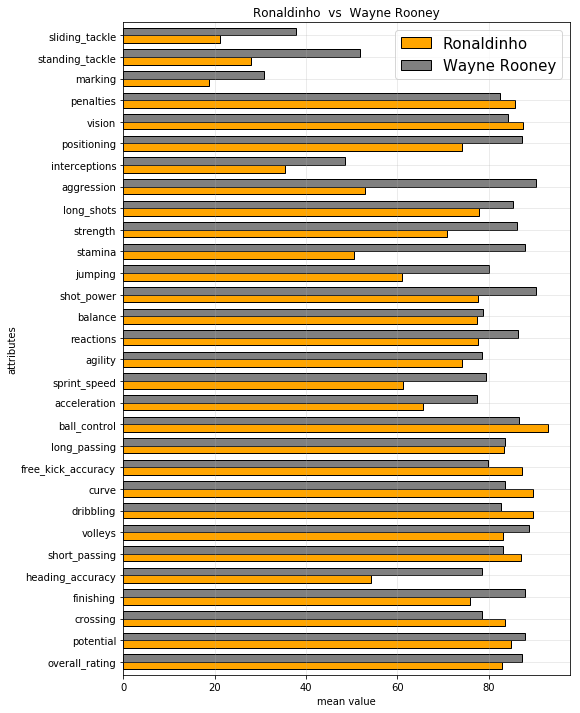

In [111]:
player_comparator( 'Ronaldinho','Wayne Rooney')

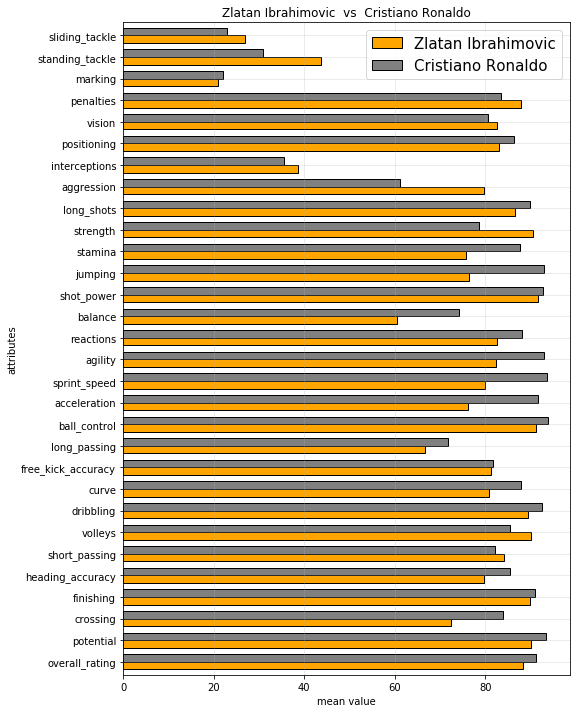

In [112]:
player_comparator('Zlatan Ibrahimovic','Cristiano Ronaldo')

### Goleiro

In [113]:
goal_keeper = player_info[["player_api_id",'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning','gk_reflexes', 'player_name',"overall_rating"]]
goal_keeper = goal_keeper[(goal_keeper["gk_diving"]>75) & (goal_keeper["gk_handling"]>75)
                          & (goal_keeper["gk_kicking"]>75)& (goal_keeper["gk_positioning"]>75)
                          & (goal_keeper["gk_reflexes"]>75) ]
goal_keeper = goal_keeper.groupby(["player_api_id","player_name"])[['gk_diving', 'gk_handling', 'gk_kicking',
                                    'gk_positioning', 'gk_reflexes', 'overall_rating']].mean()
goal_keeper = goal_keeper.sort_values(by="overall_rating",ascending =False).reset_index()
goal_keeper.index = goal_keeper["player_name"]

### Estatísticas dos Melhores Goleiros

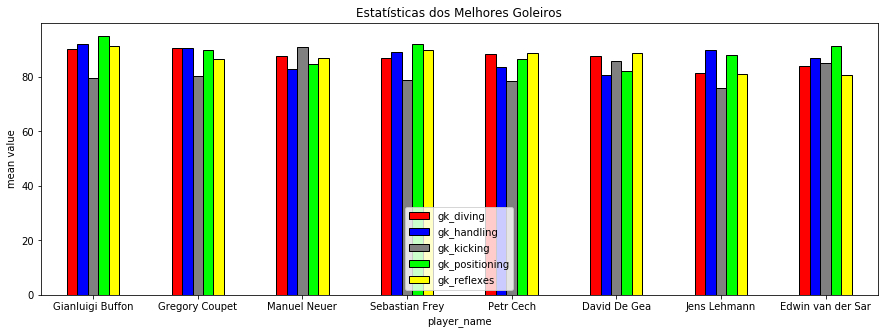

In [115]:
goal_keeper[['gk_diving', 'gk_handling', 'gk_kicking',
       'gk_positioning', 'gk_reflexes']][:8].plot(kind = "bar",figsize=(15,5),
                                                  color =["r","b","grey","lime","yellow"],
                                                  linewidth = 1,
                                                  edgecolor = "k"*10
                                                 )

plt.xticks(rotation =0)
plt.legend(loc ="lower center")
plt.ylabel("mean value")
plt.title("Estatísticas dos Melhores Goleiros")
plt.show()

### Gráficos Radar para Jogadores e Seus Atributos

In [186]:
from math import pi

In [162]:
string = ['Andres Iniesta','Cristiano Ronaldo', 'Lionel Messi','Luis Suarez','Neymar', 'Ronaldinho','Wayne Rooney','Zlatan Ibrahimovic']
play   = player_info[player_info["player_name"].isin(string)]
cols   = ["player_name",'overall_rating','potential', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'standing_tackle', 'sliding_tackle']
play = play[cols]
play = play.groupby("player_name")[cols].mean().reset_index()

In [168]:
cats = list(play)[1:]
N    = len(cats)

In [177]:
values = play.loc[0].drop("player_name").values.flatten().tolist()
values

[88.32,
 90.56,
 83.72,
 72.68,
 55.32,
 93.88,
 74.0,
 90.08,
 80.0,
 69.28,
 89.0,
 92.96,
 79.96,
 76.8,
 86.44,
 89.32,
 86.04,
 66.84,
 54.64,
 77.72,
 60.48,
 76.16,
 59.4,
 72.36,
 88.2,
 92.92,
 71.12,
 59.68,
 56.0]

In [179]:
values = play.loc[1].drop("player_name").values.flatten().tolist()
values

[91.28,
 93.48,
 83.88,
 91.12,
 85.52,
 82.28,
 85.56,
 92.64,
 88.0,
 81.64,
 71.72,
 93.96,
 91.64,
 93.76,
 92.96,
 88.16,
 74.32,
 92.76,
 93.04,
 87.6,
 78.68,
 89.88,
 61.28,
 35.64,
 86.48,
 80.68,
 83.6,
 30.84,
 23.0]

In [187]:
[n / float(N)*2*pi for n in range(N)]

[0.0,
 0.21666156231653746,
 0.43332312463307493,
 0.6499846869496123,
 0.8666462492661499,
 1.0833078115826873,
 1.2999693738992246,
 1.5166309362157622,
 1.7332924985322997,
 1.9499540608488373,
 2.1666156231653746,
 2.3832771854819117,
 2.5999387477984492,
 2.816600310114987,
 3.0332618724315243,
 3.249923434748062,
 3.4665849970645994,
 3.6832465593811365,
 3.8999081216976745,
 4.116569684014212,
 4.333231246330749,
 4.549892808647287,
 4.766554370963823,
 4.983215933280362,
 5.1998774955968985,
 5.416539057913436,
 5.633200620229974,
 5.849862182546511,
 6.066523744863049]

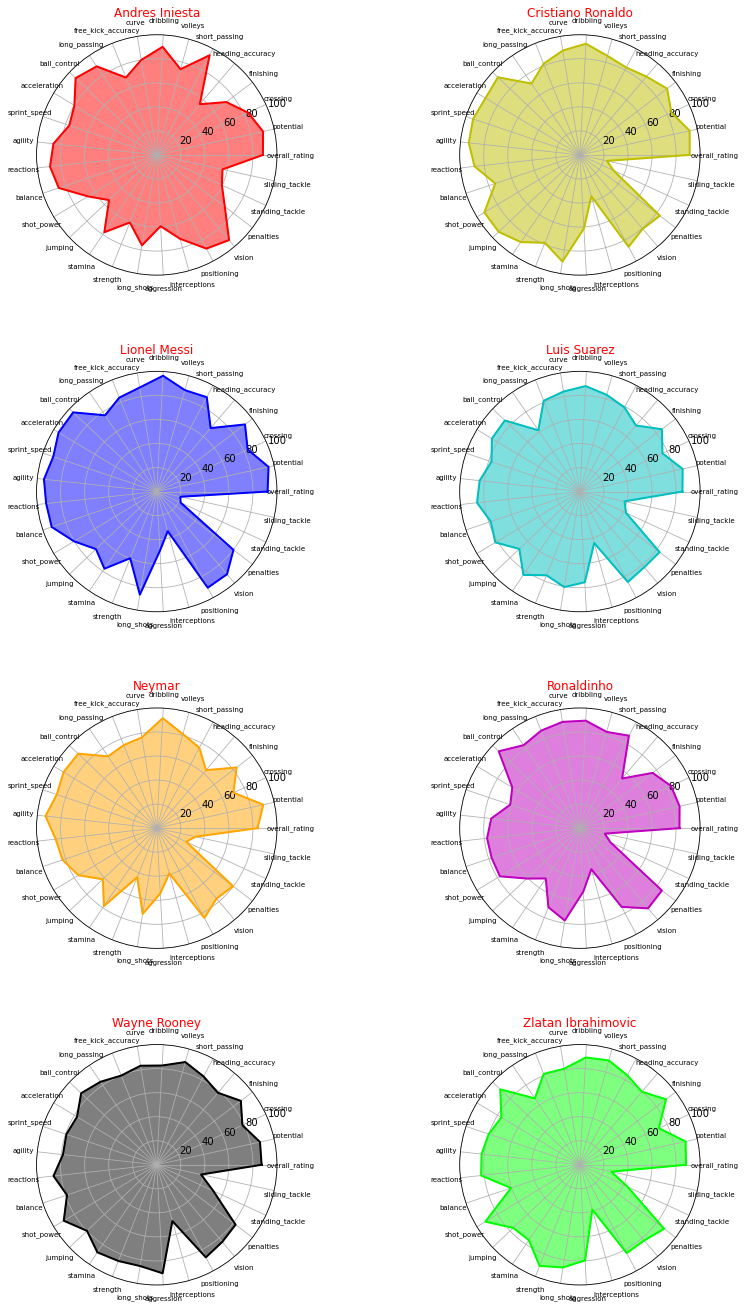

In [189]:
num = [0,1,2,3,4,5,6,7]
c = ["r","y","b","c","orange","m","k","lime"]
plt.figure(figsize=(13,23))

for i,j,k in itertools.zip_longest(num,range(len(num)),c):
    plt.subplot(4,2,j+1,projection="polar")
    cats = list(play)[1:]
    N    = len(cats)
    
    values = play.loc[i].drop("player_name").values.flatten().tolist()
    values += values[:1]
    values
    
    angles = [n / float(N)*2*pi for n in range(N)]
    angles += angles[:1]
    angles
    
    plt.xticks(angles[:-1],cats,color="k",size=7)
    plt.ylim([0,100])
    plt.plot(angles,values,color=k,linewidth=2,linestyle="solid")
    plt.fill(angles,values,color=k,alpha=0.5)
    plt.title(play["player_name"][i],color="r")
    plt.subplots_adjust(wspace=.4,hspace=.4)

plt.show()

In [412]:
values = play.loc[0].drop("player_name").values.flatten().tolist()

In [416]:
values += values[:1]

In [417]:
values

[88.32,
 90.56,
 83.72,
 72.68,
 55.32,
 93.88,
 74.0,
 90.08,
 80.0,
 69.28,
 89.0,
 92.96,
 79.96,
 76.8,
 86.44,
 89.32,
 86.04,
 66.84,
 54.64,
 77.72,
 60.48,
 76.16,
 59.4,
 72.36,
 88.2,
 92.92,
 71.12,
 59.68,
 56.0,
 88.32,
 88.32]

# Atributos dos Times

In [190]:
team_info =  team_attributes.merge(teams,left_on="team_api_id",right_on="team_api_id",how="left")

In [191]:
team_info.head()

,id_x,team_fifa_api_id_x,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,id_y,team_fifa_api_id_y,team_long_name,team_short_name
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,Medium,55,Press,45,Normal,Cover,49119,434.0,FC Aarau,AAR
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,Medium,44,Press,54,Normal,Cover,49119,434.0,FC Aarau,AAR
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,Medium,44,Press,54,Normal,Cover,49119,434.0,FC Aarau,AAR
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,Medium,70,Double,70,Wide,Cover,39393,77.0,Aberdeen,ABE
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,Medium,47,Press,52,Normal,Cover,39393,77.0,Aberdeen,ABE


In [192]:
team_info = team_info.drop(['id_x','id_y', 'team_fifa_api_id_y'],axis=1)
team_info["date"] = pd.to_datetime(team_info["date"],format="%Y-%m-%d")

In [193]:
columns= team_info.columns
cat_col= columns[columns.str.contains("Class")].tolist()
cat_col

['buildUpPlaySpeedClass',
 'buildUpPlayDribblingClass',
 'buildUpPlayPassingClass',
 'buildUpPlayPositioningClass',
 'chanceCreationPassingClass',
 'chanceCreationCrossingClass',
 'chanceCreationShootingClass',
 'chanceCreationPositioningClass',
 'defencePressureClass',
 'defenceAggressionClass',
 'defenceTeamWidthClass',
 'defenceDefenderLineClass']

In [194]:
num_col= [x for x in team_info.columns if x not in columns[columns.str.contains("Class")].tolist()+["team_api_id"]+['team_fifa_api_id_x']+["date"]+['team_long_name']+[ 'team_short_name']]

In [195]:
num_col

['buildUpPlaySpeed',
 'buildUpPlayDribbling',
 'buildUpPlayPassing',
 'chanceCreationPassing',
 'chanceCreationCrossing',
 'chanceCreationShooting',
 'defencePressure',
 'defenceAggression',
 'defenceTeamWidth']

In [196]:
categorical_team_info = team_info[cat_col+["team_api_id"]+['team_fifa_api_id_x']+["date"]+['team_long_name']+[ 'team_short_name']]
numerical_team_info   = team_info[num_col+["team_api_id"]+['team_fifa_api_id_x']+["date"]+['team_long_name']+[ 'team_short_name']]

In [148]:
categorical_team_info

,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassingClass,chanceCreationCrossingClass,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressureClass,defenceAggressionClass,defenceTeamWidthClass,defenceDefenderLineClass,team_api_id,team_fifa_api_id_x,date,team_long_name,team_short_name
0,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover,9930,434,2010-02-22,FC Aarau,AAR
1,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover,9930,434,2014-09-19,FC Aarau,AAR
2,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover,9930,434,2015-09-10,FC Aarau,AAR
3,Fast,Little,Long,Organised,Risky,Lots,Lots,Organised,Medium,Double,Wide,Cover,8485,77,2010-02-22,Aberdeen,ABE
4,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover,8485,77,2011-02-22,Aberdeen,ABE
5,Balanced,Little,Mixed,Organised,Normal,Lots,Normal,Organised,Medium,Press,Normal,Cover,8485,77,2012-02-22,Aberdeen,ABE
6,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover,8485,77,2013-09-20,Aberdeen,ABE
7,Balanced,Normal,Mixed,Organised,Normal,Lots,Normal,Organised,Medium,Press,Normal,Cover,8485,77,2014-09-19,Aberdeen,ABE
8,Balanced,Normal,Mixed,Organised,Normal,Lots,Normal,Free Form,Medium,Press,Normal,Cover,8485,77,2015-09-10,Aberdeen,ABE
9,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Deep,Double,Narrow,Offside Trap,8576,614,2010-02-22,AC Ajaccio,AJA


In [149]:
numerical_team_info

,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,team_api_id,team_fifa_api_id_x,date,team_long_name,team_short_name
0,60,NaN,50,60,65,55,50,55,45,9930,434,2010-02-22,FC Aarau,AAR
1,52,48.0,56,54,63,64,47,44,54,9930,434,2014-09-19,FC Aarau,AAR
2,47,41.0,54,54,63,64,47,44,54,9930,434,2015-09-10,FC Aarau,AAR
3,70,NaN,70,70,70,70,60,70,70,8485,77,2010-02-22,Aberdeen,ABE
4,47,NaN,52,53,48,52,47,47,52,8485,77,2011-02-22,Aberdeen,ABE
5,58,NaN,62,45,70,55,40,40,60,8485,77,2012-02-22,Aberdeen,ABE
6,62,NaN,45,40,50,55,42,42,60,8485,77,2013-09-20,Aberdeen,ABE
7,58,64.0,62,56,68,57,41,42,60,8485,77,2014-09-19,Aberdeen,ABE
8,59,64.0,53,51,72,63,49,45,63,8485,77,2015-09-10,Aberdeen,ABE
9,60,NaN,40,45,35,55,30,70,30,8576,614,2010-02-22,AC Ajaccio,AJA


In [197]:
n = numerical_team_info.groupby("team_long_name")[num_col].mean().reset_index()

In [154]:
n

,team_long_name,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,1. FC Kaiserslautern,51.166667,51.0,51.666667,47.166667,62.000000,59.666667,46.833333,52.833333,55.166667
1,1. FC Köln,57.333333,50.0,61.166667,55.166667,41.666667,59.000000,45.000000,51.166667,60.833333
2,1. FC Nürnberg,45.333333,60.0,47.500000,50.500000,53.000000,59.166667,43.333333,50.500000,44.000000
3,1. FSV Mainz 05,61.833333,48.5,51.500000,53.000000,47.666667,54.500000,52.500000,62.500000,49.666667
4,AC Ajaccio,60.166667,57.0,48.833333,50.333333,40.666667,52.166667,37.833333,50.500000,48.666667
5,AC Arles-Avignon,43.166667,47.0,53.166667,46.000000,38.333333,39.500000,38.333333,46.000000,46.333333
6,AC Bellinzona,43.500000,NaN,52.000000,55.000000,51.500000,55.000000,38.500000,50.000000,55.500000
7,ADO Den Haag,45.500000,43.5,50.000000,49.666667,56.000000,50.166667,45.500000,51.333333,52.166667
8,AJ Auxerre,53.500000,55.0,55.166667,45.666667,63.666667,47.500000,33.500000,46.666667,41.333333
9,AS Monaco,51.333333,55.0,48.666667,49.166667,42.833333,38.166667,44.333333,47.333333,54.000000


### Comparador de Times

In [158]:
def team_comparator(team1,team2):
    
    team_list = [team1,team2]
    length    = len(team_list)
    cr        = ["b","r"]
    fig = plt.figure(figsize=(15,8))
    plt.subplot(111,projection= "polar")
    
    for i,j,k in itertools.zip_longest(team_list,range(length),cr):
        cats = num_col
        N    = len(cats)
        
        values = n[n["team_long_name"] ==  i][cats].values.flatten().tolist()
        values += values[:1]
        
        angles = [n/float(N)*2*pi for n in range(N)]
        angles += angles[:1]
        
        plt.xticks(angles[:-1],cats,color="k",fontsize=15)
        plt.plot(angles,values,linewidth=3,color=k)
        plt.fill(angles,values,color = k,alpha=.4,label = i)
        plt.legend(loc="upper right",frameon =True,prop={"size":15}).get_frame().set_facecolor("lightgrey")
        fig.set_facecolor("w")
        fig.set_edgecolor("k")
        plt.title("Comparador de Times",fontsize=30,color="tomato")

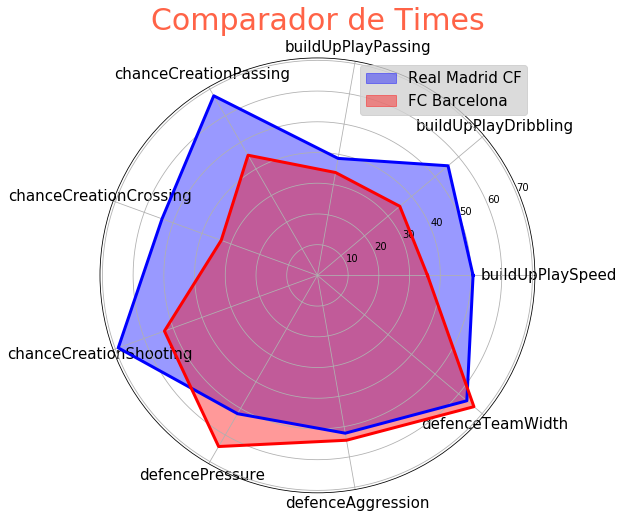

In [159]:
team_comparator("Real Madrid CF","FC Barcelona")

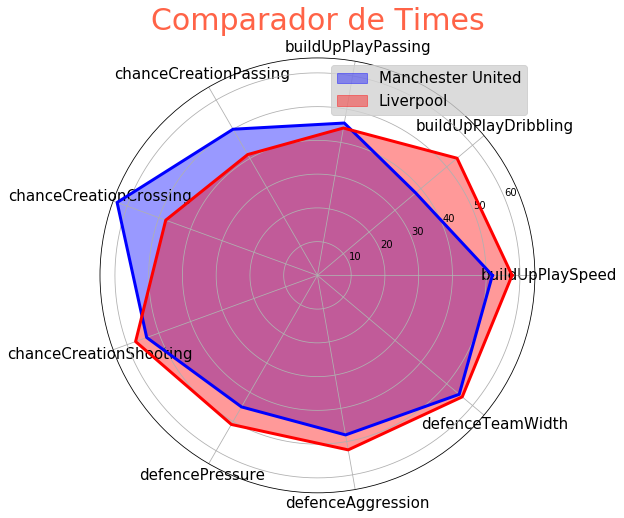

In [160]:
team_comparator("Manchester United","Liverpool")
plt.show()

# Econometria

Utilizaremos inicialmente o ``statsmodels``, ``sklearn`` e ``scipy``

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from numpy import NaN

from sklearn import linear_model

from scipy import stats

In [4]:
df = pd.read_stata("/Users/gustavorsampaio/Documents/Cursos/Python 2020.2/Aulas/auto.dta")

In [5]:
df.head()

,make,price,mpg,rep78,headroom,trunk,weight,length,turn,displacement,gear_ratio,foreign
0,AMC Concord,4099,22,3.0,2.5,11,2930,186,40,121,3.58,Domestic
1,AMC Pacer,4749,17,3.0,3.0,11,3350,173,40,258,2.53,Domestic
2,AMC Spirit,3799,22,NaN,3.0,12,2640,168,35,121,3.08,Domestic
3,Buick Century,4816,20,3.0,4.5,16,3250,196,40,196,2.93,Domestic
4,Buick Electra,7827,15,4.0,4.0,20,4080,222,43,350,2.41,Domestic


### Regressão usando StatsModels:

In [6]:
X = df["weight"]
y = df["price"]

In [201]:
X.head()

0    2930
1    3350
2    2640
3    3250
4    4080
Name: weight, dtype: int16

In [202]:
y.head()

0    4099
1    4749
2    3799
3    4816
4    7827
Name: price, dtype: int16

Inicialmente construimos o modelo e em seguida aplicamos a função ``fit()`` para "ajustar" a regressão

In [227]:
model = sm.OLS(y, X)
model

In [230]:
result = model.fit()

In [231]:
result

In [226]:
model

Podemos, agora, observar os dados da regressão

In [229]:
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):               30797.616
Model:                            OLS   Adj. R-squared (uncentered):          31219.488
Method:                 Least Squares   F-statistic:                             -73.00
Date:                Wed, 13 Jan 2021   Prob (F-statistic):                        1.00
Time:                        17:09:58   Log-Likelihood:                         -683.04
No. Observations:                  74   AIC:                                      1368.
Df Residuals:                      73   BIC:                                      1370.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

E podemos utilizar o resultado para realizar previsões

In [234]:
predictions = result.predict(X)

In [235]:
predictions.head()

0    5982.994033
1    6840.624577
2    5390.820562
3    6636.426829
4    8331.268142
dtype: float64

In [236]:
y.head()

0    4099
1    4749
2    3799
3    4816
4    7827
Name: price, dtype: int16

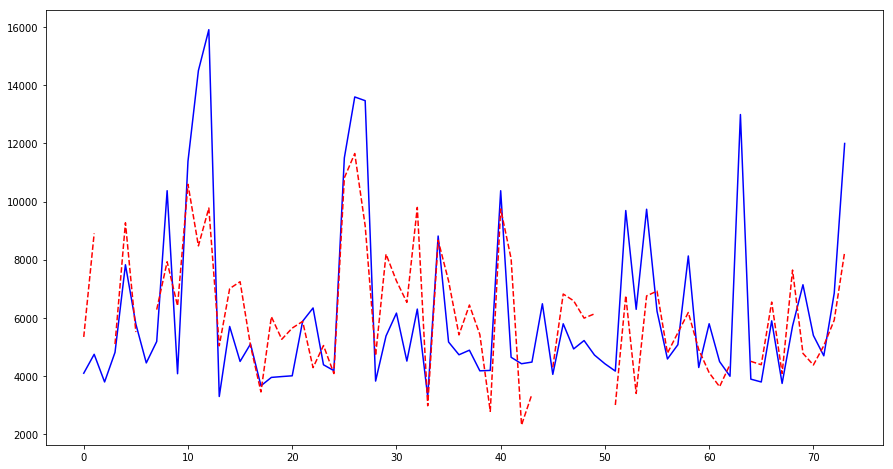

In [447]:
fig = plt.figure(figsize=(15,8))
plt.plot(range(0,len(y)), y.tolist(), 'b')
plt.plot(range(0,len(y)), predictions.tolist(), 'r--')
plt.show()

Observem que o modelo anterior não possui constante. Temos que adicionar manualmente

In [7]:
X = sm.add_constant(X)

In [238]:
X.head()

,const,weight
0,1.0,2930
1,1.0,3350
2,1.0,2640
3,1.0,3250
4,1.0,4080


In [240]:
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     29.42
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           7.42e-07
Time:                        17:18:44   Log-Likelihood:                -683.04
No. Observations:                  74   AIC:                             1370.
Df Residuals:                      72   BIC:                             1375.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7074   1174.430     -0.006      0.9

Podemos incluir mais de uma variável. Basta construir X com o número de variáveis desejadas

In [241]:
X = df[["weight", "length"]]
X = sm.add_constant(X)

In [242]:
X.head()

,const,weight,length
0,1.0,2930,186
1,1.0,3350,173
2,1.0,2640,168
3,1.0,3250,196
4,1.0,4080,222


In [243]:
y = df["price"]

In [245]:
model = sm.OLS(y, X).fit()
#predictions = model.predict(X)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     18.91
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           2.61e-07
Time:                        17:19:50   Log-Likelihood:                -679.91
No. Observations:                  74   AIC:                             1366.
Df Residuals:                      71   BIC:                             1373.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.039e+04   4308.159      2.411      0.0

Ou utilizar todas as variáveis e dropar missings

In [246]:
df

,make,price,mpg,rep78,headroom,trunk,weight,length,turn,displacement,gear_ratio,foreign
0,AMC Concord,4099,22,3.0,2.5,11,2930,186,40,121,3.58,Domestic
1,AMC Pacer,4749,17,3.0,3.0,11,3350,173,40,258,2.53,Domestic
2,AMC Spirit,3799,22,NaN,3.0,12,2640,168,35,121,3.08,Domestic
3,Buick Century,4816,20,3.0,4.5,16,3250,196,40,196,2.93,Domestic
4,Buick Electra,7827,15,4.0,4.0,20,4080,222,43,350,2.41,Domestic
...,...,...,...,...,...,...,...,...,...,...,...,...
69,VW Dasher,7140,23,4.0,2.5,12,2160,172,36,97,3.74,Foreign
70,VW Diesel,5397,41,5.0,3.0,15,2040,155,35,90,3.78,Foreign
71,VW Rabbit,4697,25,4.0,3.0,15,1930,155,35,89,3.78,Foreign
72,VW Scirocco,6850,25,4.0,2.0,16,1990,156,36,97,3.78,Foreign


In [247]:
y = df["price"]
df1 = df.drop("price",1)
df1 = df1.drop("make",1)
df1 = df1.drop("foreign",1)
X = df1
X = sm.add_constant(X)

In [248]:
X.head()

,const,mpg,rep78,headroom,trunk,weight,length,turn,displacement,gear_ratio
0,1.0,22,3.0,2.5,11,2930,186,40,121,3.58
1,1.0,17,3.0,3.0,11,3350,173,40,258,2.53
2,1.0,22,NaN,3.0,12,2640,168,35,121,3.08
3,1.0,20,3.0,4.5,16,3250,196,40,196,2.93
4,1.0,15,4.0,4.0,20,4080,222,43,350,2.41


In [249]:
model = sm.OLS(y, X)

MissingDataError: exog contains inf or nans

In [250]:
model = sm.OLS(y, X, missing='drop')

In [251]:
results = model.fit()
predictions = results.predict(X)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     6.958
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           9.13e-07
Time:                        17:22:39   Log-Likelihood:                -622.84
No. Observations:                  69   AIC:                             1266.
Df Residuals:                      59   BIC:                             1288.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.106e+04   7305.303      1.514   

Como já vimos anteriormente, podemos construir dummies e inclui-las na regressão

In [252]:
y = df["price"]
df1 = df.drop("price",1)
df1 = df1.drop("make",1)
df1 = df1.drop("foreign",1)

In [253]:
df1.head()

,mpg,rep78,headroom,trunk,weight,length,turn,displacement,gear_ratio
0,22,3.0,2.5,11,2930,186,40,121,3.58
1,17,3.0,3.0,11,3350,173,40,258,2.53
2,22,NaN,3.0,12,2640,168,35,121,3.08
3,20,3.0,4.5,16,3250,196,40,196,2.93
4,15,4.0,4.0,20,4080,222,43,350,2.41


In [254]:
dummie_foreign = pd.get_dummies(df['foreign'],prefix='dum')

In [255]:
dummie_foreign.head()

,dum_Domestic,dum_Foreign
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [256]:
X = pd.concat([df1, dummie_foreign], axis=1)

In [257]:
X.head()

,mpg,rep78,headroom,trunk,weight,length,turn,displacement,gear_ratio,dum_Domestic,dum_Foreign
0,22,3.0,2.5,11,2930,186,40,121,3.58,1,0
1,17,3.0,3.0,11,3350,173,40,258,2.53,1,0
2,22,NaN,3.0,12,2640,168,35,121,3.08,1,0
3,20,3.0,4.5,16,3250,196,40,196,2.93,1,0
4,15,4.0,4.0,20,4080,222,43,350,2.41,1,0


In [258]:
X = X.drop("dum_Foreign",1)

In [259]:
X.head()

,mpg,rep78,headroom,trunk,weight,length,turn,displacement,gear_ratio,dum_Domestic
0,22,3.0,2.5,11,2930,186,40,121,3.58,1
1,17,3.0,3.0,11,3350,173,40,258,2.53,1
2,22,NaN,3.0,12,2640,168,35,121,3.08,1
3,20,3.0,4.5,16,3250,196,40,196,2.93,1
4,15,4.0,4.0,20,4080,222,43,350,2.41,1


In [260]:
model = sm.OLS(y, X, missing='drop')
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):               11232.670
Model:                            OLS   Adj. R-squared (uncentered):          13136.342
Method:                 Least Squares   F-statistic:                             -5.901
Date:                Wed, 13 Jan 2021   Prob (F-statistic):                        1.00
Time:                        17:27:03   Log-Likelihood:                         -618.48
No. Observations:                  69   AIC:                                      1257.
Df Residuals:                      59   BIC:                                      1279.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

Podemos utilizar a systaxe do R

In [261]:
dat = df
results = smf.ols('np.log(price) ~ weight + length', data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     16.56
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           1.25e-06
Time:                        17:28:35   Log-Likelihood:                -21.048
No. Observations:                  74   AIC:                             48.10
Df Residuals:                      71   BIC:                             55.01
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.7478      0.585     14.941      0.0

# Regressão usando o Sklearn

In [262]:
X = df[["weight"]]
y = df["price"]

In [263]:
X.head()

,weight
0,2930
1,3350
2,2640
3,3250
4,4080


In [264]:
lm = linear_model.LinearRegression()

In [265]:
lm

LinearRegression()

In [266]:
model = lm.fit(X,y)

In [267]:
model

LinearRegression()

Recuperando os coeficientes, intercepto e $R^2$ 

In [268]:
lm.coef_

array([2.04406259])

In [269]:
lm.intercept_

-6.707353351665006

In [270]:
lm.score(X,y)

0.2901023076446273

Podemos, também, realizar previsões

In [271]:
predictions = lm.predict(X)
print(predictions[0:5])

[5982.39602274 6840.90230873 5389.61787289 6636.49605016 8333.06799629]


### plot da Regressão

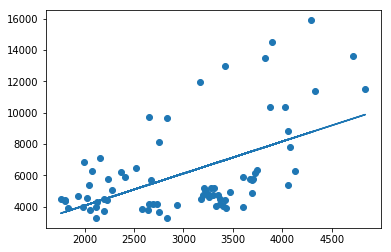

In [229]:
yfit = model.predict(X)
plt.scatter(X,y)
plt.plot(X,yfit)
plt.show()

# Regressão usando o Scipy

In [232]:
X = np.array([0,1,2,3,4,5])
Y = np.array([3,4, 5, 10, 2, 5])

In [233]:
stats.linregress(X,Y)

LinregressResult(slope=0.2571428571428572, intercept=4.19047619047619, rvalue=0.17262001662906243, pvalue=0.7436418122140313, stderr=0.7336424827646003)

## Regressão Linear Robusta

In [272]:
X = df[["weight"]]
y = df["price"]

In [273]:
model = sm.RLM(y, X, missing='drop', M=sm.robust.norms.HuberT())
results = model.fit()
print(results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                  price   No. Observations:                   74
Model:                            RLM   Df Residuals:                       73
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 13 Jan 2021                                         
Time:                        17:36:17                                         
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weight         1.9234      0.081     23.714      0.0

## Comparar OLS e RLM

``linspace``: Return evenly spaced numbers over a specified interval

In [274]:
nsample = 50
x1 = np.linspace(0, 20, nsample)
X = np.column_stack((x1, (x1-5)**2))
X = sm.add_constant(X)

In [276]:
X

array([[1.00000000e+00, 0.00000000e+00, 2.50000000e+01],
       [1.00000000e+00, 4.08163265e-01, 2.10849646e+01],
       [1.00000000e+00, 8.16326531e-01, 1.75031237e+01],
       [1.00000000e+00, 1.22448980e+00, 1.42544773e+01],
       [1.00000000e+00, 1.63265306e+00, 1.13390254e+01],
       [1.00000000e+00, 2.04081633e+00, 8.75676801e+00],
       [1.00000000e+00, 2.44897959e+00, 6.50770512e+00],
       [1.00000000e+00, 2.85714286e+00, 4.59183673e+00],
       [1.00000000e+00, 3.26530612e+00, 3.00916285e+00],
       [1.00000000e+00, 3.67346939e+00, 1.75968347e+00],
       [1.00000000e+00, 4.08163265e+00, 8.43398584e-01],
       [1.00000000e+00, 4.48979592e+00, 2.60308205e-01],
       [1.00000000e+00, 4.89795918e+00, 1.04123282e-02],
       [1.00000000e+00, 5.30612245e+00, 9.37109538e-02],
       [1.00000000e+00, 5.71428571e+00, 5.10204082e-01],
       [1.00000000e+00, 6.12244898e+00, 1.25989171e+00],
       [1.00000000e+00, 6.53061224e+00, 2.34277384e+00],
       [1.00000000e+00, 6.93877

In [241]:
sig = 0.3   # smaller error variance makes OLS<->RLM contrast bigger
beta = [5, 0.5, -0.0]
y_true2 = np.dot(X, beta) # multiplicar dois arrays

In [242]:
y_true2

array([ 5.        ,  5.20408163,  5.40816327,  5.6122449 ,  5.81632653,
        6.02040816,  6.2244898 ,  6.42857143,  6.63265306,  6.83673469,
        7.04081633,  7.24489796,  7.44897959,  7.65306122,  7.85714286,
        8.06122449,  8.26530612,  8.46938776,  8.67346939,  8.87755102,
        9.08163265,  9.28571429,  9.48979592,  9.69387755,  9.89795918,
       10.10204082, 10.30612245, 10.51020408, 10.71428571, 10.91836735,
       11.12244898, 11.32653061, 11.53061224, 11.73469388, 11.93877551,
       12.14285714, 12.34693878, 12.55102041, 12.75510204, 12.95918367,
       13.16326531, 13.36734694, 13.57142857, 13.7755102 , 13.97959184,
       14.18367347, 14.3877551 , 14.59183673, 14.79591837, 15.        ])

In [243]:
y2 = y_true2 + sig*1. * np.random.normal(size=nsample)
y2[[39,41,43,45,48]] -= 5   # add some outliers (10% of nsample)

In [244]:
y2

array([ 4.85604244,  5.17892684,  5.2592509 ,  5.94428305,  5.56327872,
        6.13816929,  6.02994942,  6.25176237,  6.61578556,  7.32533431,
        7.41419598,  7.07873761,  7.48741248,  7.57165223,  8.12829584,
        8.55834266,  8.18192323,  8.65294935,  8.76553118,  8.94335375,
        9.45254452,  9.57987671,  9.30894219, 10.00567976, 10.00404746,
       10.17942015, 10.98468011, 10.67875417, 10.72854382, 11.05483791,
       11.20013222, 11.67050459, 11.19270256, 11.90807959, 11.77287547,
       12.16391571, 12.26631582, 12.51882089, 13.07418171,  7.99942402,
       12.86203295,  7.87898597, 13.42174065,  8.38155235, 14.79929919,
        9.77162444, 14.56031491, 14.2388494 ,  9.97695517, 14.87878457])

In [245]:
res = sm.OLS(y2, X).fit()
print(res.params)

[ 5.0776713   0.53803083 -0.01488909]


In [246]:
resrlm = sm.RLM(y2, X).fit()
print(resrlm.params)

[ 4.98909720e+00  5.27478073e-01 -4.84266216e-03]


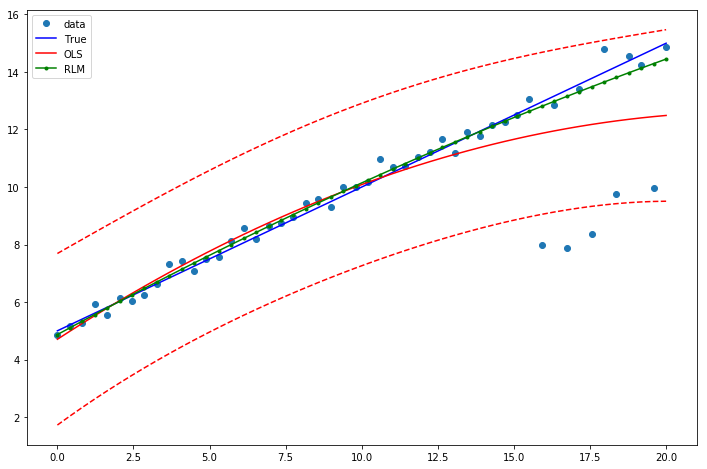

In [247]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(x1, y2, 'o',label="data")
ax.plot(x1, y_true2, 'b-', label="True")
prstd, iv_l, iv_u = wls_prediction_std(res)
ax.plot(x1, res.fittedvalues, 'r-', label="OLS")
ax.plot(x1, iv_u, 'r--')
ax.plot(x1, iv_l, 'r--')
ax.plot(x1, resrlm.fittedvalues, 'g.-', label="RLM")
ax.legend(loc="best")
plt.show()

## Logit e Probit

In [10]:
dummie_foreign = pd.get_dummies(df['foreign'],prefix='foreign')
Y = dummie_foreign["foreign_Domestic"]
X = df[["weight", "length"]]
X = sm.add_constant(X)

In [22]:
df

,make,price,mpg,rep78,headroom,trunk,weight,length,turn,displacement,gear_ratio,foreign
0,AMC Concord,4099,22,3.0,2.5,11,2930,186,40,121,3.58,Domestic
1,AMC Pacer,4749,17,3.0,3.0,11,3350,173,40,258,2.53,Domestic
2,AMC Spirit,3799,22,NaN,3.0,12,2640,168,35,121,3.08,Domestic
3,Buick Century,4816,20,3.0,4.5,16,3250,196,40,196,2.93,Domestic
4,Buick Electra,7827,15,4.0,4.0,20,4080,222,43,350,2.41,Domestic
...,...,...,...,...,...,...,...,...,...,...,...,...
69,VW Dasher,7140,23,4.0,2.5,12,2160,172,36,97,3.74,Foreign
70,VW Diesel,5397,41,5.0,3.0,15,2040,155,35,90,3.78,Foreign
71,VW Rabbit,4697,25,4.0,3.0,15,1930,155,35,89,3.78,Foreign
72,VW Scirocco,6850,25,4.0,2.0,16,1990,156,36,97,3.78,Foreign


In [9]:
Y

0     1
1     1
2     1
3     1
4     1
     ..
69    0
70    0
71    0
72    0
73    0
Name: foreign_Domestic, Length: 74, dtype: uint8

In [12]:
X.head()

,const,weight,length
0,1.0,2930,186
1,1.0,3350,173
2,1.0,2640,168
3,1.0,3250,196
4,1.0,4080,222


In [13]:
logit_mod = sm.Logit(Y, X)

In [14]:
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 48.238428
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       foreign_Domestic   No. Observations:                   74
Model:                          Logit   Df Residuals:                       71
Method:                           MLE   Df Model:                            2
Date:                Wed, 20 Jan 2021   Pseudo R-squ.:                     inf
Time:                        14:45:21   Log-Likelihood:                -3569.6
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.3662      5.775     -0.929      0.353     -16.686       5.953
weight         0.0028      0

/Users/gustavorsampaio/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/gustavorsampaio/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/gustavorsampaio/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3409: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


In [15]:
print(logit_res.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: inf      
Dependent Variable: foreign_Domestic AIC:              7145.2873
Date:               2021-01-20 14:49 BIC:              7152.1995
No. Observations:   74               Log-Likelihood:   -3569.6  
Df Model:           2                LL-Null:          0.0000   
Df Residuals:       71               LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
------------------------------------------------------------------
          Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
------------------------------------------------------------------
const    -5.3662     5.7753   -0.9292   0.3528   -16.6857   5.9532
weight    0.0028     0.0017    1.6953   0.0900    -0.0004   0.0061
length   -0.0089     0.0543   -0.1643   0.8695    -0.1153   0.0975



In [16]:
probit_mod = sm.Probit(Y, X)
probit_res = probit_mod.fit()
print(probit_res.summary2())

         Current function value: 0.000000
         Iterations: 35
                          Results: Probit
Model:                Probit           Pseudo R-squared: inf        
Dependent Variable:   foreign_Domestic AIC:              6.0000     
Date:                 2021-01-20 14:50 BIC:              12.9122    
No. Observations:     74               Log-Likelihood:   -2.7587e-12
Df Model:             2                LL-Null:          0.0000     
Df Residuals:         71               LLR p-value:      1.0000     
Converged:            0.0000           Scale:            1.0000     
No. Iterations:       35.0000                                       
--------------------------------------------------------------------
        Coef.    Std.Err.     z    P>|z|      [0.025       0.975]   
--------------------------------------------------------------------
const   5.8513 944136.3093  0.0000 1.0000 -1850467.3114 1850479.0140
weight -0.0011    499.7307 -0.0000 1.0000     -979.4552     979.

/Users/gustavorsampaio/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Em Logit e Probit, não estamos interessados nos coeficientes da regressão em si. Mas nos efeitos marginais

In [260]:
print(probit_res.get_margeff(at='overall', method='dydx').summary())

       Probit Marginal Effects       
Dep. Variable:       foreign_Domestic
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weight     -2.884e-16   2.17e-10  -1.33e-06      1.000   -4.24e-10    4.24e-10
length      7.634e-15   5.73e-09   1.33e-06      1.000   -1.12e-08    1.12e-08


In [17]:
X

,const,weight,length
0,1.0,2930,186
1,1.0,3350,173
2,1.0,2640,168
3,1.0,3250,196
4,1.0,4080,222
...,...,...,...
69,1.0,2160,172
70,1.0,2040,155
71,1.0,1930,155
72,1.0,1990,156


In [20]:
predictions = probit_res.predict([[1.0, 2930, 186]])

In [21]:
predictions

array([1.])

# Regressão Quantílica

Gerar dados com variância constante

loc : Mean (“centre”) of the distribution.

scale : Standard deviation (spread or “width”) of the distribution.


In [24]:
import numpy as np
x = np.arange(100).reshape(100,1) 
intercept_ = 6 
slope_ = 0.1 
## erro não constante 
error_ = np.random.normal(size = (100,1), loc = 0.0, scale = 1) 
## Equação da Regressão 
y = intercept_ + slope_ * x + error_  

In [29]:
y

array([[ 7.84181996],
       [ 6.41412621],
       [ 6.50158047],
       [ 5.02141087],
       [ 6.39859451],
       [ 6.54155735],
       [ 7.65386338],
       [ 6.29469674],
       [ 5.54305445],
       [ 5.53868452],
       [ 7.69367607],
       [ 6.37628567],
       [ 6.02748964],
       [ 7.5538643 ],
       [ 8.38695351],
       [ 8.21622185],
       [ 7.11235782],
       [ 8.65035401],
       [ 8.97658468],
       [ 6.29446385],
       [ 6.6649205 ],
       [ 7.57658836],
       [ 7.34833536],
       [ 8.3325324 ],
       [10.0540493 ],
       [10.41997856],
       [ 9.60125087],
       [ 8.00395396],
       [ 9.34471775],
       [ 9.98067118],
       [10.24976938],
       [ 9.44222929],
       [ 9.76863881],
       [ 9.00706223],
       [ 7.71873373],
       [ 9.6318943 ],
       [11.27550381],
       [10.64839838],
       [12.20448611],
       [12.04396275],
       [ 7.94564644],
       [11.82949708],
       [11.07061498],
       [ 9.88876145],
       [10.55092744],
       [10

In [273]:
x[0:5]

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [275]:
error_[0:5]

array([[ 0.52683515],
       [ 0.27765122],
       [ 0.80015149],
       [-0.57307441],
       [-0.47177009]])

In [276]:
y[0:5]

array([[6.52683515],
       [6.37765122],
       [7.00015149],
       [5.72692559],
       [5.92822991]])

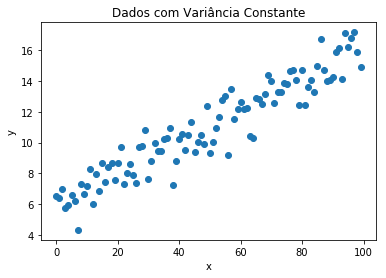

In [278]:
plt.figure(1) 
plt.scatter(x, y) 
plt.xlabel("x") 
plt.ylabel("y") 
plt.title("Dados com Variância Constante")
plt.show()

Vamos rodar uma OLS nos dados acima

In [33]:
model1 = linear_model.LinearRegression(fit_intercept = True, normalize = False) 
res = model1.fit(x, y)

In [36]:
res.coef_

array([[0.10070835]])

In [37]:
res.intercept_

array([6.1296195])

In [38]:
y_pred1 = res.predict(x)

In [40]:
y_pred1[0:5]

array([[6.1296195 ],
       [6.23032785],
       [6.33103619],
       [6.43174454],
       [6.53245289]])

In [41]:
y[0:5]

array([[7.84181996],
       [6.41412621],
       [6.50158047],
       [5.02141087],
       [6.39859451]])

In [84]:
ols = model1.coef_

In [85]:
ols

array([[0.10070835]])

In [42]:
print("Mean squared error: {0:.2f}".format(np.mean((y_pred1 - y) ** 2))) 
print('Variance score: {0:.2f}'.format(model1.score(x, y)))

Mean squared error: 1.12
Variance score: 0.88


Vamos plotar a regressão

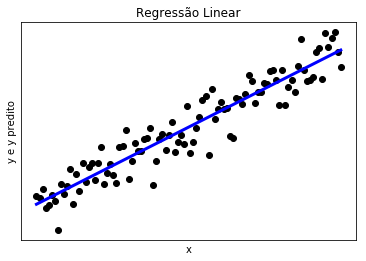

In [293]:
plt.figure(2) 
plt.scatter(x, y, color='black') 
plt.plot(x, y_pred1, color='blue', linewidth=3)  
plt.xticks(()) 
plt.yticks(()) 
plt.xlabel("x") 
plt.ylabel("y e y predito") 
plt.title("Regressão Linear")
plt.show()

Vamos agora gerar dados com variância não constante

In [44]:
x_ = np.arange(100).reshape(100,1) 
intercept_ = 6 
slope_ = 0.1 
## Variância não constante 
var_ = 0.1 + 0.05 * x_ 
## erro não constante 
error_ = np.random.normal(size = (100,1), loc = 0.0, scale = var_) 

In [289]:
x_[0:5]

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [290]:
var_[0:5]

array([[0.1 ],
       [0.15],
       [0.2 ],
       [0.25],
       [0.3 ]])

In [292]:
error_[0:5]

array([[-0.10566513],
       [ 0.2566773 ],
       [-0.2436602 ],
       [-0.03424591],
       [-0.03715458]])

In [46]:
## Equação da Regressão 
y_ = intercept_ + slope_ * x + error_  

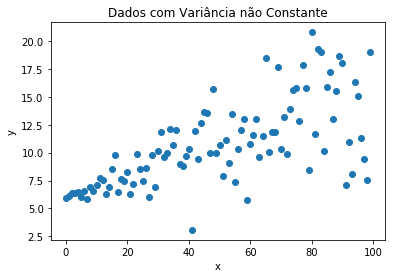

In [296]:
plt.figure(3) 
plt.scatter(x_, y_) 
plt.xlabel("x") 
plt.ylabel("y") 
plt.title("Dados com Variância não Constante")
plt.show()

Vamos tentar ajustar uma regressão linear

In [47]:
model2 = linear_model.LinearRegression(fit_intercept = True, normalize = False) 
res2 = model2.fit(x_, y_)

In [48]:
y_pred2 = res2.predict(x_)

In [49]:
y_pred2[0:5]

array([[6.27717011],
       [6.37309151],
       [6.46901291],
       [6.56493431],
       [6.66085571]])

In [50]:
ols2 = res2.coef_

In [317]:
print(ols2)

[[0.08904415]]


In [302]:
print("Mean squared error: {0:.2f}".format(np.mean((y_pred2 - y_) ** 2))) 
print('Variance score: {0:.2f}'.format(model1.score(x_, y_)))

Mean squared error: 8.02
Variance score: 0.44


Vamos plotar a regressão

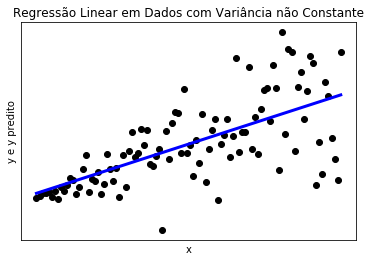

In [303]:
plt.figure(4) 
plt.scatter(x_, y_, color='black') 
plt.plot(x_, y_pred2, color='blue', linewidth=3)  
plt.xticks(()) 
plt.yticks(()) 
plt.xlabel("x") 
plt.ylabel("y e y predito") 
plt.title("Regressão Linear em Dados com Variância não Constante")
plt.show()

Vamos, agora, rodar uma Regressão Quantílica para a mediana dos dados (Quantil 0.5)

In [51]:
data = pd.DataFrame(data = np.hstack([x_, y_]), columns = ["x", "y"]) 

In [52]:
data.head()

,x,y
0,0.0,6.064356
1,1.0,6.216078
2,2.0,6.519837
3,3.0,6.110537
4,4.0,6.245314


In [53]:
mod = smf.quantreg('y ~ x', data)

In [54]:
mod

In [55]:
res = mod.fit(q=.5) 
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.3090
Model:                       QuantReg   Bandwidth:                       2.349
Method:                 Least Squares   Sparsity:                        6.180
Date:                Wed, 20 Jan 2021   No. Observations:                  100
Time:                        15:26:01   Df Residuals:                       98
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1040      0.613      9.951      0.000       4.887       7.321
x              0.0959      0.011      8.957      0.000       0.075       0.117


Construir o modelo para outros quantis

In [58]:
quantiles = np.arange(0.1,1,0.1) 
print(quantiles) 

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [78]:
models = [] 
params = []  
for qt in quantiles:  
    print(qt)  
    res = mod.fit(q = qt )
    models.append(res)
    params.append([qt, res.params['Intercept'], res.params['x']] + [res.conf_int()[0]['x'],res.conf_int()[1]['x']])

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9


In [79]:
params

[[0.1,
  5.998217997381195,
  0.03743966098264001,
  0.017188179320732327,
  0.057691142644547694],
 [0.2,
  5.966598169333462,
  0.04797959487919223,
  0.022681088636034623,
  0.07327810112234984],
 [0.30000000000000004,
  5.975721828037674,
  0.06739820012571168,
  0.04260194094291715,
  0.09219445930850621],
 [0.4,
  6.064355050243133,
  0.08801416547369495,
  0.06640837976572865,
  0.10961995118166125],
 [0.5,
  6.104016093458156,
  0.0958822761772331,
  0.07463833841172916,
  0.11712621394273705],
 [0.6,
  6.103404308868583,
  0.1126749124741957,
  0.09164675070170375,
  0.13370307424668765],
 [0.7000000000000001,
  6.083639387314232,
  0.1324384268165399,
  0.10927517220773053,
  0.15560168142534925],
 [0.8,
  6.231049993211066,
  0.14862487681463987,
  0.12411959692026381,
  0.17313015670901594],
 [0.9,
  6.629300035526441,
  0.16005804070423735,
  0.13607264194488963,
  0.18404343946358506]]

In [77]:
res.conf_int()[0]['x']

0.017188179320732327

In [ ]:
models

In [321]:
params

[[0.1,
  5.951431631347507,
  0.025358763877119085,
  -0.0015097953936952964,
  0.05222732314793346],
 [0.2,
  6.009067907055815,
  0.054241204419297515,
  0.03001490812791916,
  0.07846750071067587],
 [0.30000000000000004,
  6.07509073131167,
  0.06916090613048932,
  0.046405257542545125,
  0.09191655471843352],
 [0.4,
  6.059290041417766,
  0.08496268127253497,
  0.06451901638402377,
  0.10540634616104616],
 [0.5,
  6.060189998496438,
  0.09458458874346108,
  0.07531838828146492,
  0.11385078920545724],
 [0.6,
  6.035505578143043,
  0.10946228330603232,
  0.09057161890622008,
  0.12835294770584454],
 [0.7000000000000001,
  5.981507778667608,
  0.130365793805712,
  0.109847506653829,
  0.150884080957595],
 [0.8,
  6.219200483041011,
  0.13160672492267717,
  0.11524311335822673,
  0.1479703364871276],
 [0.9,
  6.264566746123947,
  0.158354780032555,
  0.14270152434213024,
  0.17400803572297974]]

In [80]:
params = pd.DataFrame(data = params, columns = ['qt','intercept','x_coef','cf_lower_bound','cf_upper_bound'])  
print(params)

    qt  intercept    x_coef  cf_lower_bound  cf_upper_bound
0  0.1   5.998218  0.037440        0.017188        0.057691
1  0.2   5.966598  0.047980        0.022681        0.073278
2  0.3   5.975722  0.067398        0.042602        0.092194
3  0.4   6.064355  0.088014        0.066408        0.109620
4  0.5   6.104016  0.095882        0.074638        0.117126
5  0.6   6.103404  0.112675        0.091647        0.133703
6  0.7   6.083639  0.132438        0.109275        0.155602
7  0.8   6.231050  0.148625        0.124120        0.173130
8  0.9   6.629300  0.160058        0.136073        0.184043


Plot dos dados e de cada regressão

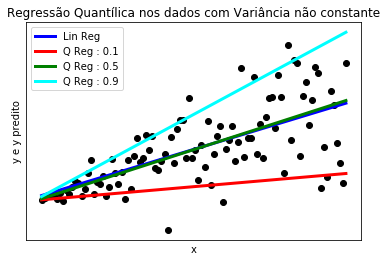

In [333]:
plt.figure(5) 
plt.scatter(x_, y_,  color='black') 
plt.plot(x_, y_pred2, color='blue', linewidth=3, label='Lin Reg')  
y_pred3 = models[0].params['Intercept'] + models[0].params['x'] * x_ 
plt.plot(x_, y_pred3, color='red', linewidth=3, label='Q Reg : 0.1')  
y_pred4 = models[4].params['Intercept'] + models[4].params['x'] * x_ 
plt.plot(x_, y_pred4, color='green', linewidth=3, label='Q Reg : 0.5')   
y_pred5 = models[8].params['Intercept'] + models[8].params['x'] * x_ 
plt.plot(x_, y_pred5, color='cyan', linewidth=3, label='Q Reg : 0.9')   
plt.xticks(()) 
plt.yticks(()) 
plt.xlabel("x") 
plt.ylabel("y e y predito") 
plt.title("Regressão Quantílica nos dados com Variância não constante") 
plt.legend()
plt.show()

Plotar mudanças nos coeficientes dos quantís

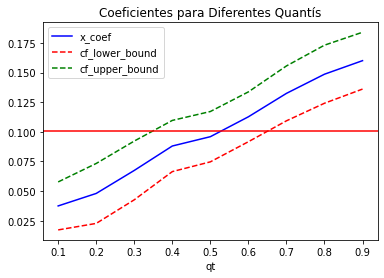

In [86]:
params.plot(x = 'qt', y = ['x_coef','cf_lower_bound', 'cf_upper_bound'], title = 'Coeficientes para Diferentes Quantís', kind ='line', style = ['b-','r--','g--'])
plt.axhline(y=ols, color='r', linestyle='-')
plt.show()